Measuring modernity in Scandinavian literature
==================

Code in support of the article "Deep distant reading: The rise of realism in Scandinavian literature as a case study" by Jens Bjerring-Hansen and Matthew Wilkens, _Orbis Litterarum_ (2023).

# Imports and configuration

In [1]:
# Imports

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import shap # throws a NumbaDeprecationWarning

from   collections import defaultdict
import matplotlib.pyplot as plt
from   matplotlib import cm, colors as mplcolors, style
import numpy as np
import os
import pandas as pd
from   pathlib import Path
import scipy
import seaborn as sns
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest
from   sklearn.linear_model import LinearRegression, LogisticRegression
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import datetime
import zipfile

In [2]:
# Flags
#  Slow steps; if False, load saved results from disk
do_nlp = False 
if do_nlp:
    import spacy
    spacy.prefer_gpu()
    nlp = spacy.load('da_core_news_trf')
    nlp.max_length = 2000000

# File locations
res_dir = 'results'
fig_dir = 'figures'
dat_dir = os.path.join ('..','data')
cor_dir = os.path.join(dat_dir, 'corpus')
fea_dir = os.path.join(dat_dir, 'features')
dan_dir = os.path.join(dat_dir, 'dannet', 'DanNet-2.2_csv')

corpus_file = os.path.join(cor_dir, 'romankorpus.v0.5.zip') # zipped directory of texts
metadata_file = os.path.join(cor_dir, 'romankorpus_metadata_v0.5_2022-06-03.xlsx') # metadata (Excel file)
labels_file = os.path.join(cor_dir, 'romankorpus_metadata_v0.5_2022-06-07(realism).xlsx')
feature_pred_file = os.path.join(fea_dir, 'realism-feature-predictions.xlsx')

os.makedirs(fig_dir, exist_ok=True)
os.makedirs(res_dir, exist_ok=True)
os.makedirs(dat_dir, exist_ok=True)

# Colors
palette = sns.color_palette('muted')
plot_colors = {
    'm':palette[0],     # blue
    'f':palette[1],     # orange
    
    'dk':palette[3],    # red
    'no':palette[4],    # purple
    
    'cheap':palette[7], # silver
    'expensive':palette[8], # gold
    
    'short':palette[6], # pink (like red) for stop
    'long':palette[2],  # green for go
    
    'main':palette[9],  # blue for first place
    'other':palette[5], # brown for blah
    
    'roman':'darkkhaki',# Rome is kinda beige ;)
    'gothic':'black'    # black like black letter
}

# Plotting options
figsize_std = (12,8)
plt.rc('figure', figsize=figsize_std)
plt.rcParams['figure.figsize'] = figsize_std
sns.set_context(context='talk', rc={'figure.figsize':figsize_std})
sns.set_style('whitegrid', {'grid.color': '.9'})

# Load data

## Metadata

In [3]:
metadata = pd.read_excel(
    metadata_file,
    sheet_name='Data',
)

# clean up some data entry oddities
for col in ['pages', 'novel_start', 'novel_end', 'price']:
    metadata[col] = pd.to_numeric(metadata[col], errors='coerce')

# strip whitespace in text columns
text_columns = metadata.select_dtypes(include='object').columns
metadata[text_columns] = metadata[text_columns].transform(lambda x: x.str.strip())

# drop records without filename
metadata.dropna(subset=['filename'], inplace=True)
    
# set filename without extension as index
metadata['filename'] = metadata['filename'].apply(lambda x: Path(x).stem)
metadata.set_index('filename', inplace=True)

### Magdalene Thoresen

Magdalene Thoresen's nationality is treated inconsistently in the metadata. She is listed once as `dk` and once as `dk-no`. Setting to `dk`, since `dk-no` is not otherwise used.

In [4]:
metadata.loc['1879_Thoresen_HerlufNordal', 'nationality'] = 'dk'

### Fix typos

There are typos in the metadata, of course. Fix the ones that we notice and that could impact the analysis.

In [5]:
# 't' -> 'y' (adjacent keys) in illustrations column 
metadata.loc['1887_Muusmann_ForfloejnePile', 'illustrations'] = 'y'

## Labels

In [6]:
labels = pd.read_excel(
    labels_file,
    sheet_name='Data',
    usecols=['filename', 'realism'],
)

# drop records without label
labels.dropna(subset=['realism'], inplace=True)

# set filename without extension as index
labels['filename'] = labels['filename'].apply(lambda x: Path(x).stem)
labels.set_index('filename', inplace=True)

## Corpus

In [7]:
corpus_dictionary = {}
with zipfile.ZipFile(corpus_file) as z:
    for filename in z.namelist():
        if Path(filename).suffix=='.txt':
            fileid = Path(filename).stem
            corpus_dictionary[fileid] = z.read(filename).decode('utf-8')

corpus = pd.DataFrame.from_dict(corpus_dictionary, orient='index', columns=['text'])
del corpus_dictionary

## Restrict corpus and labels to good files with metadata

In [8]:
metadata = metadata.loc[corpus.index]
corpus = corpus.loc[metadata.index]
labels = labels.loc[labels.index.isin(corpus.index)]

# Characterize the metadada

Some basic visualizations and statistics.

In [9]:
print("Entries in the metadata:", len(metadata))
print("Volumes marked 'discard':", sum(metadata.discard=='y'))

Entries in the metadata: 839
Volumes marked 'discard': 0


## Composition

### Author gender

Volume counts by author gender
m    598
f    145
Name: gender, dtype: int64


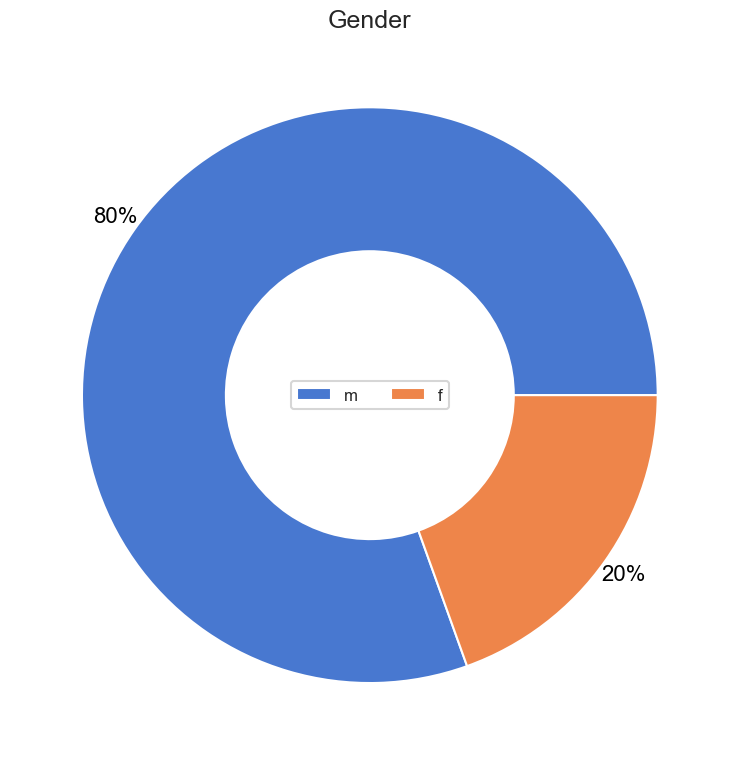

In [10]:
# counts
print("Volume counts by author gender")
print(metadata.gender.value_counts())

# plot
for i in range(2): #need to plot twice to make formatting stick :/
    with style.context('seaborn-pastel'):
        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=figsize_std)
        plt.subplot(1,1,1)
        plt.title("Gender")
        patches, texts, _ = plt.pie(
            metadata.gender.value_counts(), 
            autopct='%1.0f%%',
            textprops=dict(color='k', size=16, weight='regular'),
            wedgeprops=dict(width=0.5),
            pctdistance=1.08,
            colors=[plot_colors['m'], plot_colors['f']]
        )
        plt.legend(
            patches, 
            metadata.gender.value_counts().index, 
            ncol=2,
            prop={'size': 12},
            loc='center'
        )
        plt.tight_layout()
        if i==1:
            plt.savefig(os.path.join(fig_dir, f'corpus_gender.png'), dpi=300)
        else:
            plt.close()

### Author gender in pseudonymous texts

Are women overrepresented among authors publishing pseudonymously? Answer: a bit, yes.

In [11]:
# select volumes published pseudonymously
pseud = metadata.loc[~metadata['pseudonym'].isna()]
print("Author genders in pseudonymous volumes:")
print(pseud.groupby('gender')['year'].count())

Author genders in pseudonymous volumes:
gender
f     38
m    105
Name: year, dtype: int64


In [12]:
female_fraction_total = metadata.gender.value_counts()['f']/metadata.gender.count()
female_fraction_pseud = pseud.gender.value_counts()['f']/pseud.gender.count()
print(f"Fraction female authors overall: {female_fraction_total:.3f}")
print(f"               ... pseudonymous: {female_fraction_pseud:.3f}")

Fraction female authors overall: 0.195
               ... pseudonymous: 0.266


### Nation

Volume counts by nation
dk    627
no    122
Name: nationality, dtype: int64


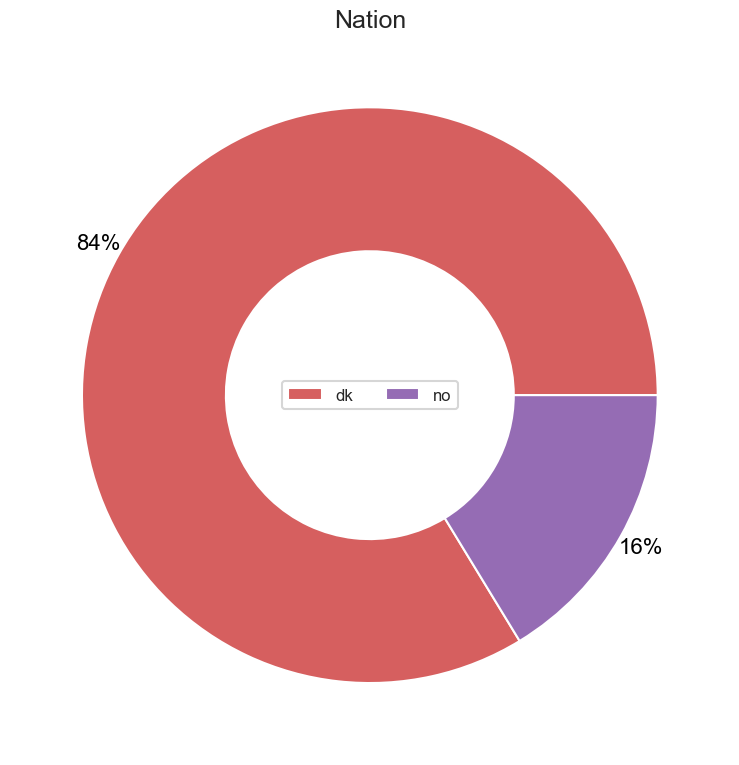

In [13]:
print("Volume counts by nation")
print(metadata.nationality.value_counts())

# plot
with style.context('seaborn-pastel'):
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=figsize_std)
    plt.subplot(1,1,1)
    plt.title("Nation")
    patches, texts, _ = plt.pie(
        metadata.nationality.value_counts(), 
        autopct='%1.0f%%',
        textprops=dict(color='k', size=16, weight='regular'),
        wedgeprops=dict(width=0.5),
        pctdistance=1.08,
        colors=[plot_colors['dk'], plot_colors['no']]
    )
    plt.legend(
        patches, 
        metadata.nationality.value_counts().index, 
        ncol=2,
        prop={'size': 12},
        loc='center'
    )
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f'corpus_nation.png'), dpi=300)
    plt.show()

### Publication dates

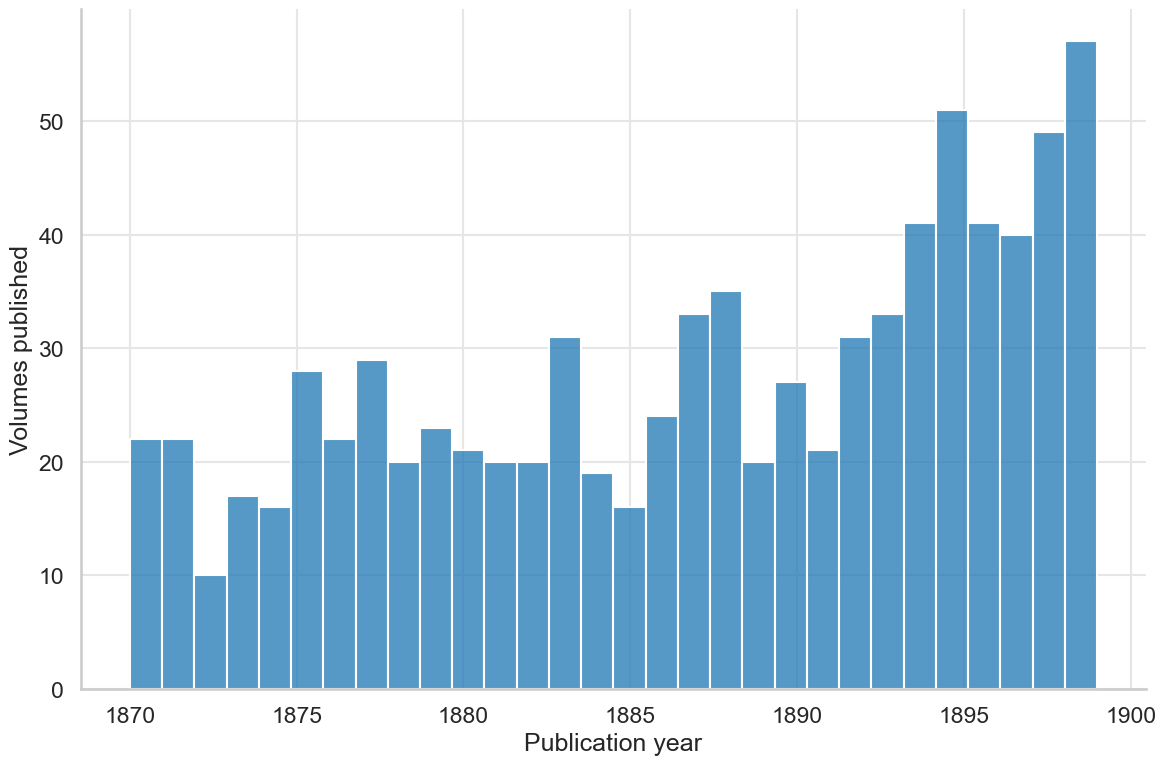

In [14]:
sns.displot(
    data=metadata,
    x='year', 
    kind='hist',
    height=8,
    aspect=1.5,
    bins=metadata.year.nunique(),
    legend=False,
    facet_kws={
        'margin_titles':'False',        
    }, 
)
plt.xlabel('Publication year')
plt.ylabel('Volumes published')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'corpus_years.png'), dpi=300)
plt.show()

### Publication dates by author gender

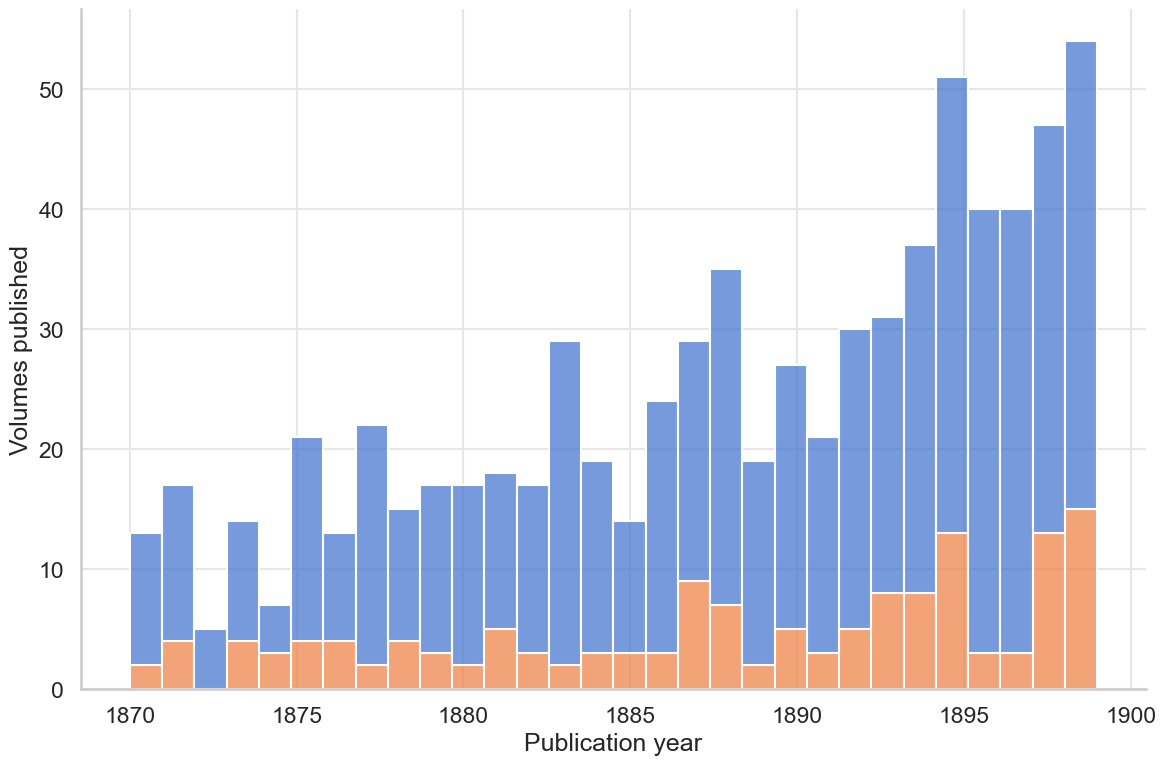

In [15]:
sns.displot(
    data=metadata,
    x='year',
    hue='gender',
    palette=plot_colors,
    multiple='stack',
    height=8,
    aspect=1.5,
    bins=metadata.year.nunique(),
    legend=False,
    facet_kws={
        'margin_titles':'False',        
    }, 
)
plt.xlabel('Publication year')
plt.ylabel('Volumes published')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'corpus_years_gender_stackedbar.png'), dpi=300)
plt.show()

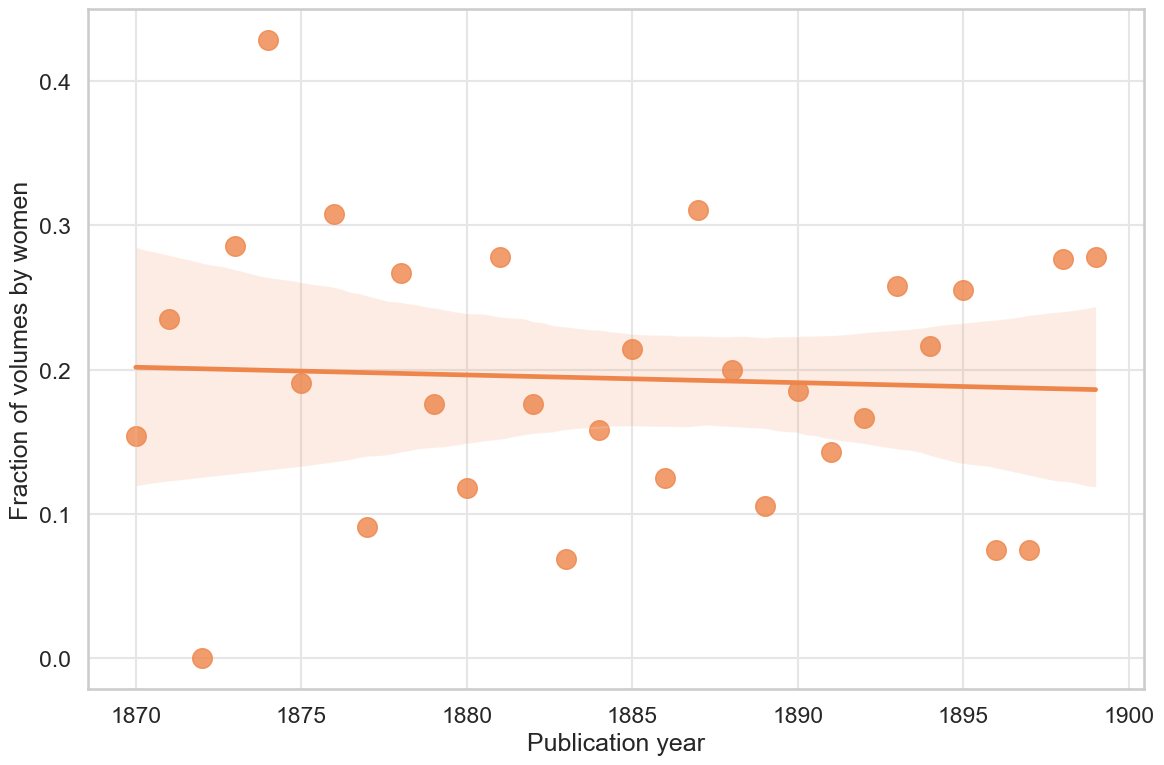

In [16]:
# compute author gender fraction by year
years = []
female_fractions = []
for year, group in metadata.groupby('year'):
    years.append(int(year))
    try:
        f_count = group.gender.value_counts().loc['f']
    except KeyError:
        f_count = 0
    female_fractions.append(f_count/group.gender.value_counts().sum())
    
sns.regplot(
    x=years,
    y=female_fractions,
    scatter_kws={
        's':200,
        'color':plot_colors['f']
    },
    line_kws={'color':plot_colors['f']}
)
plt.xlabel('Publication year')
plt.ylabel('Fraction of volumes by women')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'corpus_years_gender_fraction.png'), dpi=300)
plt.show()

### Price

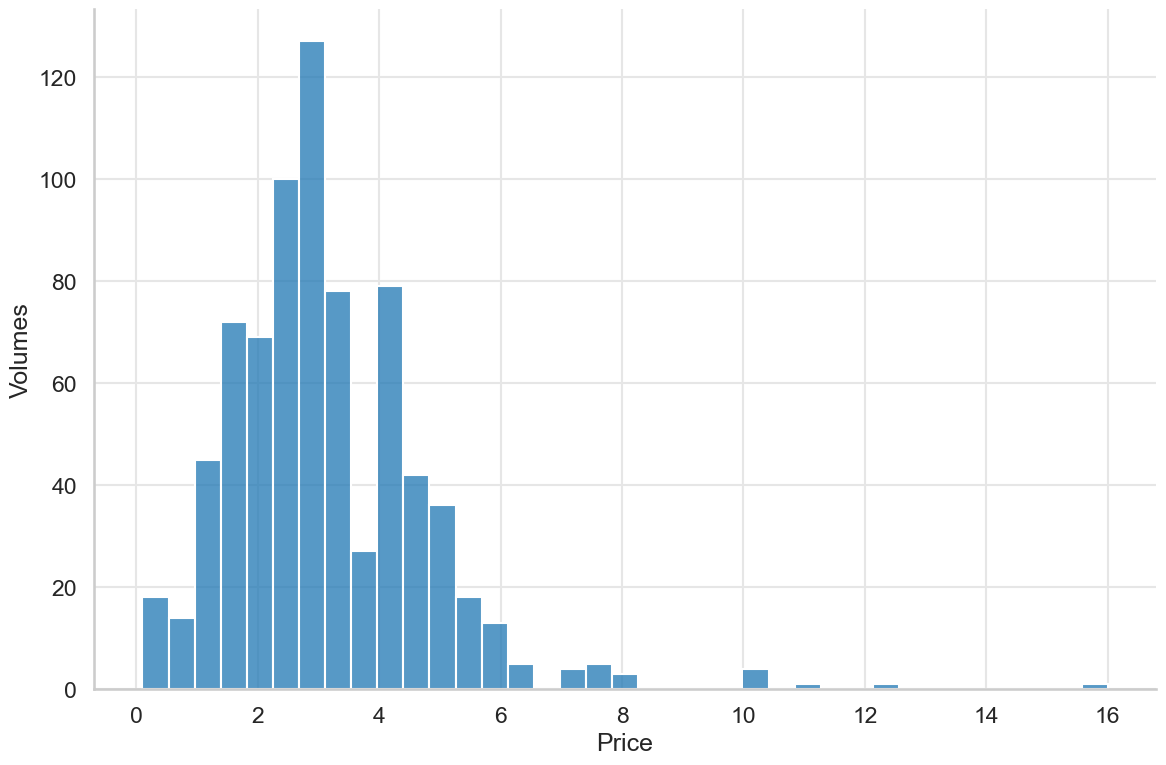

In [17]:
sns.displot(
    data=metadata,
    x='price', 
    kind='hist',
    height=8,
    aspect=1.5,
    legend=False,
    facet_kws={
        'margin_titles':'False',        
    }, 
)
plt.xlabel('Price')
plt.ylabel('Volumes')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'corpus_prices.png'), dpi=300)
plt.show()

### Page count

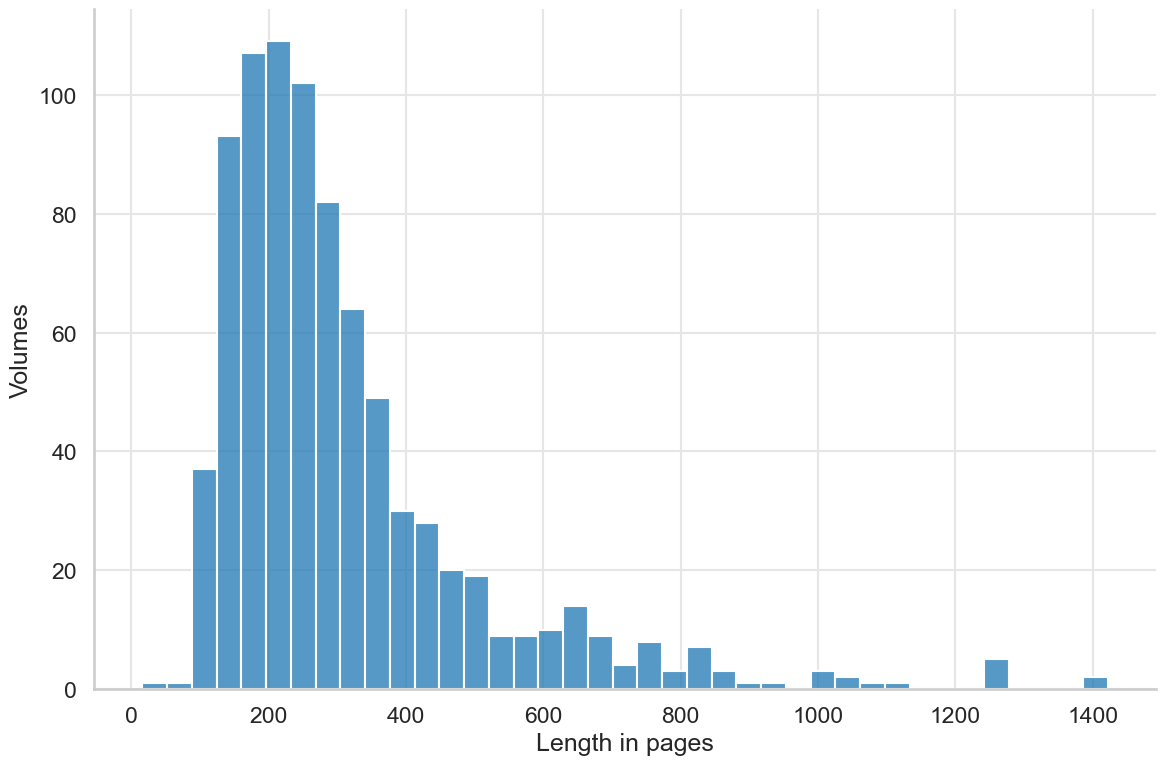

In [18]:
sns.displot(
    data=metadata,
    x='pages', 
    kind='hist',
    height=8,
    aspect=1.5,
    legend=False,
    facet_kws={
        'margin_titles':'False',        
    }, 
)
plt.xlabel('Length in pages')
plt.ylabel('Volumes')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'corpus_page_counts.png'), dpi=300)
plt.show()

## Descriptive statistics

Use these stats to compare the number of books by gender and nationality within each corpus, as well as the average publication dates between corpora.

In [19]:
print("Total volumes in the study:", len(metadata))
print(round(metadata[['year']].describe(),1))
print(round(metadata.groupby(['gender']).year.describe(),1))
print(round(metadata.groupby(['nationality']).year.describe(),1))
print(round(metadata.groupby(['gender', 'nationality']).year.describe(),1))

Total volumes in the study: 839
         year
count   839.0
mean   1887.1
std       8.8
min    1870.0
25%    1880.0
50%    1888.0
75%    1895.0
max    1899.0
        count    mean  std     min     25%     50%     75%     max
gender                                                            
f       145.0  1888.4  8.7  1870.0  1881.0  1890.0  1895.0  1899.0
m       598.0  1888.1  8.3  1870.0  1882.0  1890.0  1895.0  1899.0
             count    mean  std     min     25%     50%     75%     max
nationality                                                            
dk           627.0  1888.5  8.7  1870.0  1882.0  1891.0  1896.0  1899.0
no           122.0  1887.2  6.7  1870.0  1882.0  1887.0  1892.0  1899.0
                    count    mean  std     min     25%     50%     75%     max
gender nationality                                                            
f      dk           115.0  1888.9  8.9  1870.0  1883.0  1891.0  1896.0  1899.0
       no            28.0  1887.3  7.2  1873.0  1

# Token-based classifier

We have 29 total training examples for the `realism` label. Let's see how we perform with a very simple logistic regression classifier.

**NB.** The article uses the output of the *mixed-features* classifier, built later in this notebook.

In [20]:
# assemble labels and texts
labeled_texts = labels.join(corpus)
print("Realism label counts:")
labeled_texts.realism.value_counts()

Realism label counts:


y    15
n    14
Name: realism, dtype: int64

## Performance and feature importance

In [21]:
# vectorize
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(labeled_texts['text'])

# examine accuracy for varying number of features
for k in [5, 10, 20, 50, 500, 5000, 100000]:
    selector = SelectKBest(k=k) # score f_classif by default
    best_features = selector.fit_transform(X=features, y=labeled_texts['realism'])

    if k == 50: # save data for k = 50
        fifty_features = selector.get_feature_names_out(vectorizer.get_feature_names_out())
        fifty_scores = np.log10(selector.pvalues_[selector.get_support()])
        fifty_selector = selector
        fifty_X = fifty_selector.fit_transform(X=features, y=labeled_texts['realism'])
        fifty_df = pd.DataFrame(
            scipy.sparse.csr_matrix.todense(fifty_X),
            index=labeled_texts.index,
            columns=fifty_features
        )
        fifty_df['gold_label'] = labeled_texts['realism']
        fifty_g = fifty_df.groupby('gold_label')

    cv = cross_val_score(LogisticRegression(), best_features, labeled_texts['realism'], cv=3)
    print(f"Cross-validated accuracy for k={k}:\t{round(np.mean(cv), 3)}\t{np.round(cv, 3)}")

Cross-validated accuracy for k=5:	0.667	[0.5 0.5 1. ]
Cross-validated accuracy for k=10:	0.63	[0.5   0.5   0.889]
Cross-validated accuracy for k=20:	0.63	[0.5   0.5   0.889]
Cross-validated accuracy for k=50:	0.63	[0.5   0.5   0.889]
Cross-validated accuracy for k=500:	0.63	[0.5   0.5   0.889]
Cross-validated accuracy for k=5000:	0.7	[0.6 0.5 1. ]
Cross-validated accuracy for k=100000:	0.83	[1.    0.6   0.889]


In [22]:
def get_gold_class_for_feature(g, name):
    '''
    Take a Pandas df grouped by label and a column name.
    Return the label of the class for which the mean value in the column is higher.
    '''
    return g[name].mean().idxmax()

# display most distinctive features
print("\nMost distinctive features (alphabetical):")
longest_word = len(max(fifty_features, key=len))
print('Token       log_10(p) Realist?')
print('------------------------------')
for i in range(len(fifty_features)):
    print(f'{fifty_features[i]: <{longest_word}} {round(fifty_scores[i], 1)}',
          '    ',
          get_gold_class_for_feature(fifty_g, fifty_features[i])
         )

print('\nMost distinctive features (importance by log_10(p)):')
print('log_10(p) Token        Realist?')
print('------------------------------')

true_realism_labels_per_token_feature = []
tokens_by_importance = []

for i in np.argsort(fifty_scores):
    token = fifty_features[i]
    tokens_by_importance.append(token)
    true_label = get_gold_class_for_feature(fifty_g, fifty_features[i])
    true_realism_labels_per_token_feature.append(true_label)
    print(round(fifty_scores[i], 1),
          '    ',
          f'{token: <{longest_word+1}}',
          true_label
         )


Most distinctive features (alphabetical):
Token       log_10(p) Realist?
------------------------------
altid       -5.0      y
bemærket    -5.7      n
berøvet     -5.4      n
besiddelse  -4.6      n
besluttede  -5.1      n
betale      -4.9      n
bringe      -6.1      n
dertil      -5.0      n
faae        -5.7      n
fil         -6.6      n
fint        -6.9      y
foer        -5.3      n
forlade     -7.0      n
forlod      -6.8      n
fortælling  -5.5      n
frygte      -4.8      n
ført        -5.4      n
gaaer       -5.0      n
helt        -5.9      y
hævne       -5.1      n
knnde       -4.7      n
leilighed   -5.0      n
lykkedes    -5.3      n
mit         -5.4      n
naturligvis -4.8      y
navn        -5.0      n
nervøst     -4.7      y
opgang      -5.1      n
ren         -4.6      y
seer        -4.6      n
sfal        -5.6      n
sikkre      -5.3      n
skjøndt     -5.2      n
stal        -4.8      n
sted        -5.2      n
stive       -4.8      y
tilbage     -6.0      n
tilbud 

## Realism over time

Learn from our labeled volumes, predict over all books, show results. Basic token model.

In [23]:
# vectorize the corpus
vectorizer = TfidfVectorizer(min_df=2, max_df=len(corpus)-1)
X = vectorizer.fit_transform(corpus['text'])

In [24]:
# select training data
train_idx = corpus.index.isin(labels.index)
X_train = X[train_idx]
y_train = labels['realism']

# fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

# predict over corpus
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

In [25]:
# accuracy on train set
print("Accuracy on labeled texts:", accuracy_score(y_train, y_pred[train_idx]))

Accuracy on labeled texts: 1.0


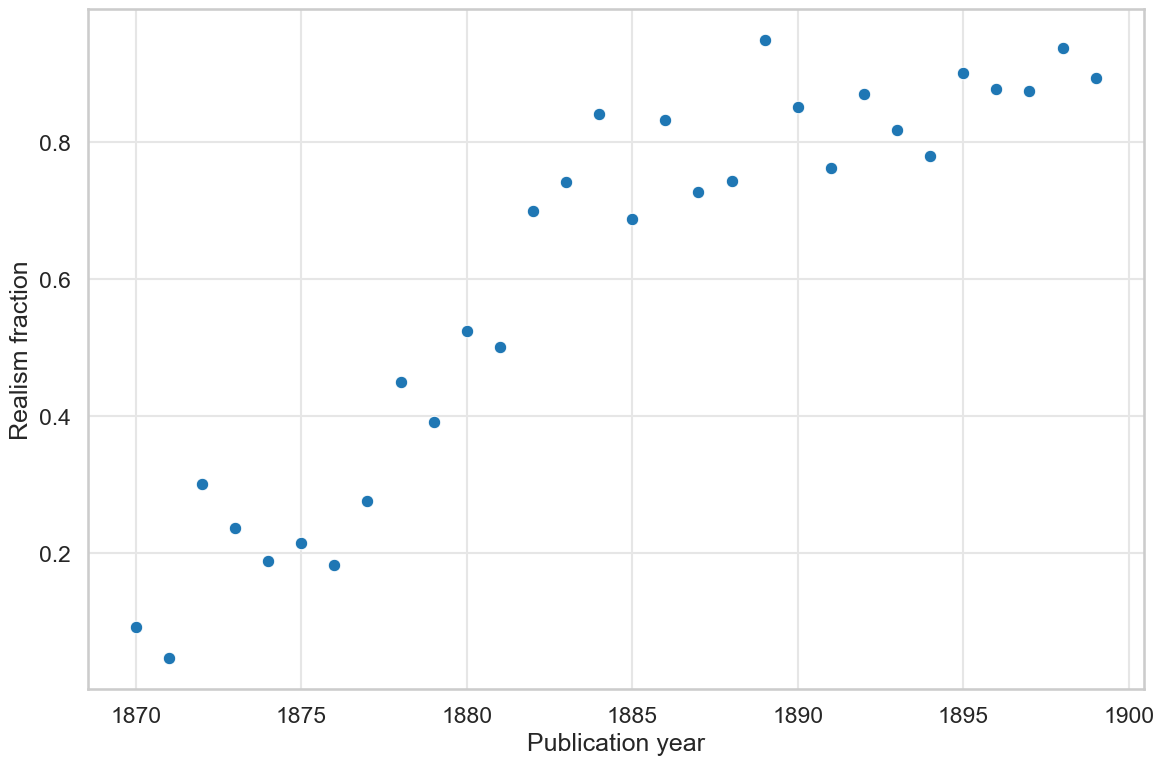

In [26]:
# plot realism fraction by year
year_label = metadata[['year']].copy()
year_label['label'] = y_pred

years = []
realism_fraction = []
for name, group in year_label.groupby(['year']):
    years.append(int(name))
    realism_fraction.append(sum(group['label']=='y')/len(group))

sns.scatterplot(x=years, y=realism_fraction)
plt.xlabel('Publication year')
plt.ylabel('Realism fraction')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'realism_pred_by_year_token.png'), dpi=300)
plt.show()

# NLP

Investigate specific word types as indicators of realism. We're working to turn the general idea of a "manifold of detail" (Strindberg, Bang) into something quantifiable.

We will:

* Count total words, excluding punctuation
* Count total common nouns, proper nouns, numbers, adjectives, and adverbs
* Count noun phrases (number and total length)
* Count adjectives that depend on common nouns
* Count concrete (not abstract) nouns as determined by DanNet

## DanNet

Read in DanNet data if and only if doing NLP processing pass, else skip.

In [27]:
if do_nlp:
    # read DanNet data
    dannet_words = pd.read_csv(
        os.path.join(dan_dir, 'words.csv'),
        sep='@',
        encoding='iso8859-1',
        names=['word_id', 'word', 'pos', '_ignore'],
        usecols=['word_id', 'word', 'pos']
    ).set_index('word_id')

    dannet_synsets = pd.read_csv(
        os.path.join(dan_dir, 'synsets.csv'),
        sep='@',
        encoding='iso8859-1',
        names=['synset_id', 'label', 'gloss', 'onto_type', '_ignore'],
        usecols=['synset_id', 'label', 'onto_type'],
    ).set_index('synset_id').dropna(subset='onto_type') # one NaN, a typo

    dannet_wordsenses = pd.read_csv(
        os.path.join(dan_dir, 'wordsenses.csv'),
        sep='@',
        encoding='iso8859-1',
        names=['wordsense_id', 'word_id', 'synset_id', 'register', '_ignore'],
        usecols=['wordsense_id', 'word_id', 'synset_id'],
    ).set_index('wordsense_id')
    # cast synset ids to int where possible
    dannet_wordsenses.loc[
        dannet_wordsenses.synset_id.str.isnumeric(), 'synset_id'
    ] = dannet_wordsenses.loc[
        dannet_wordsenses.synset_id.str.isnumeric(), 'synset_id'
    ].astype(int)

    # targeted synsets: artifact, food, possession, object, substance, animal, plant (via Tenen)
    # get all words belonging to synsets with ontological type beginning ...
    onto_types_to_include = set([
        'Animal',
        'Artifact',
        'Building',
        'Comestible',
        'Container',
        'Covering',
        'Furniture',
        'Garment',
        'Instrument', # equipment, music, etc.
        'Object',
        'Plant',
        'Vehicle'
    ])

    # alternatively, just drop words from excluded types
    onto_types_to_exclude = set([
        '2ndOrderEntity',
        '3rdOrderEntity',
        'BoundedEvent',
        'Dynamic',
        'Form',
        'Group',
        'Human', # humans are excluded by design
        'ImageRepresentation', # most words here are abstract symbols
        'LanguageRepresentation',
        'Liquid', # water, waves, splashes; not really possessable objects
        'MoneyRepresentation', # can be abstract ('depreciation'), and not often an object in the usual sense    
        'Place',
        'Property',
        'Relation',
        'Representation',
        'Static',
        'Substance',
        'UnboundedEvent'
    ])

    onto_type_lists = {
        'include':onto_types_to_include,
        'exclude':onto_types_to_exclude
    }

    for key in onto_type_lists:
        print(f"Ontological types to {key}:", sorted(onto_type_lists[key]))
        print()

    # get words from targeted ontological types
    onto_type_word_sets = {}

    for key in onto_type_lists:
        print(f"\nBuilding set of words to {key} ...")

        # function to select targeted ontological types from longer strings
        def select_onto_type(onto_string):
            top_type = onto_string.split('+')[0]
            return top_type in onto_type_lists[key]

        # select synsets
        targeted_synsets = dannet_synsets.loc[dannet_synsets.onto_type.apply(select_onto_type)]
        print("  Synsets included:", len(targeted_synsets))

        # get word ids from selected synsets
        targeted_wordsenses = dannet_wordsenses.loc[dannet_wordsenses.synset_id.isin(targeted_synsets.index)]
        print("  Words included:", targeted_wordsenses.word_id.nunique())

        # get targeted words from word ids
        targeted_words = dannet_words.loc[
            list(targeted_wordsenses.word_id)
        ]
        targeted_words = targeted_words.loc[targeted_words['pos']=='Noun']
        targeted_words.word = targeted_words.word.apply(str.lower)

        # convert targeted words to set
        targeted_word_set = set(targeted_words['word'])
        print("  Final word set size:", len(targeted_word_set))

        onto_type_word_sets[key] = targeted_word_set

## Calculate NLP-based properties

This is very slow on CPU, so will generally require a GPU-backed machine and/or cluster.

In [28]:
# if do_nlp, calculate nlp features. slow. use gpu.
# else load pre-calculated features from disk

if do_nlp:
    print(f"Processing {len(corpus)} volumes at {datetime.datetime.now()}") 
    corpus_features = {}
    noun_objects = set(['conj', 'iobj', 'nusbj', 'obj'])
    max_text_length = 1000000 # if text length (in characters) exceeds this limit, break into smaller pieces

    for i, t in enumerate(corpus['text']):
        #print(f"  Begin volume {corpus.index[i]}")
        #print(f"    Total length (characters): {len(t)}") 
        # chunk texts over max_text_length
        num_text_chunks = (len(t) // max_text_length) + 1
        text_chunk_length = len(t) // num_text_chunks + 1
        text_chunks = [t[jdx:jdx+text_chunk_length] for jdx in range(0, len(t), text_chunk_length)]
        #print(f"    {num_text_chunks} chunks of length {text_chunk_length}. Actual: {len(text_chunks)} chunks of lengths {[len(ch) for ch in text_chunks]}")
        
        # iterate over text chunks
        for chunk_number, text_chunk in enumerate(text_chunks):
            #print(f"      Begin chunk {chunk_number}")
            idx = corpus.index[i]+'.'+str(chunk_number) # get index key for text

            # do NLP
            doc = nlp(text_chunk)

            # counters
            feature_dict = defaultdict(int)
            object_list_include = [] # objects from positive inclusion list
            object_list_exclude = [] # objects from negative exclusion list
            ent_dict = defaultdict(list) # entities

            for token in doc:
                if (token.pos_ == 'SPACE') | (token.pos_ == 'PUNCT'): # ignore spaces and punctuation
                    continue
                feature_dict['wordcount'] += 1 # count words
                feature_dict[f'POS_{token.pos_}'] += 1 # count all parts of speech
                if token.pos_ == 'ADJ': # count adjectives modifying common nouns
                    if token.head.pos_ == 'NOUN':
                        feature_dict['adj_mod_nounc'] += 1 
                #dep_types[token.dep_] += 1
                if token.dep_ in noun_objects: # track material objects
                    if token.pos_ == 'NOUN': # select nouns only
                        if token.text.lower() in onto_type_word_sets['include']: # use inclusion set
                            object_list_include.append(token.text.lower())
                        if token.text.lower() not in onto_type_word_sets['exclude']: # use exclusion set
                            object_list_exclude.append(token.text.lower())
                if token.is_stop: # count stopwords (for possible exclusion from counts)
                    feature_dict['stopwords'] += 1
            feature_dict['objects_inc'] = len(object_list_include)
            feature_dict['objects_inc_u'] = len(set(object_list_include))
            feature_dict['objects_exc'] = len(object_list_exclude)
            feature_dict['objects_exc_u'] = len(set(object_list_exclude))

            for chunk in doc.noun_chunks:
                if len(chunk) > 1:
                    feature_dict['nphrases'] += 1 # count noun phrases (not bare nouns)
                    feature_dict['nphrases_length'] += len(chunk) # total length of all noun phrases
            for ent in doc.ents:
                feature_dict[f'ENT_{ent.label_}'] += 1 # count all entities
                ent_dict[ent.label_].append(ent.text.lower())
            for key in ent_dict:
                feature_dict[f'ENT_{key}_U'] = len(set(ent_dict[key]))
            corpus_features[idx] = dict(sorted(feature_dict.items()))

        # write out results after every text (ineffecient, but not the slow step)
        properties = pd.DataFrame.from_dict(corpus_features, orient='index')
        properties.to_csv(os.path.join(res_dir, 'corpus_nlp_properties.csv'))
        
        # update user on progress
        if i==0:
            print(f"Completed first volume at {datetime.datetime.now()}")
        if (i+1)%50 == 0: 
            print(f"{i+1} volumes complete  at {datetime.datetime.now()}")
    print(f"Finished processing {i+1} volumes at {datetime.datetime.now()}")
else:
    print("Reading NLP-based properties from disk")
    properties = pd.read_csv(
        os.path.join(res_dir, 'corpus_nlp_properties.csv'),
        index_col=0
    )

Reading NLP-based properties from disk


## Examine NLP properties

### Note on labels

The NLP-based features have interpretable names:

* `ENT_`: counts of named entities
  * Entity types are `LOC` (location), `PER` (person), `ORG` (organization), and `MISC` (miscellaneous)
* `POS_`: counts of parts of speech
  * Part-of-speech tags use the [UPOS tagging scheme](https://universaldependencies.org/u/pos/)
* `adj_mod_nounc`: count of adjectives modifying common (not proper) nouns
* `nphrases`: count of noun phrases of length > 1 (that is, multiword noun phrases)
* `nphrases_length`: total words contained in multiword noun phrases; divide by `nphrases` to get average noun phrase length
* `objects_`: counts of noun objects per code above
  * `_inc`: noun objects selected via the positive inclusion synsets
  * `_exc`: noun objects selected via the negative exclusion synsets
  * `_u`: *unique* noun objects
* `stopwords`: count of common words. These are also included in total wordcount
* `wordcount`: total words in the volume, excluding punctuation; the only feature not reported on length-normalized basis; can be used to reconstruct original (unnormalized) counts.

**Note further that all counts are *length normalized***, hence reported as the number of occurrences per 100,000 words. If we count 20 instances of a feature in a book that is 50,000 words long, we record the count of that feature as 40 (= 20 * 100,000/50,000).

First, aggregate the properties data by volume (from chunked results during processing) and normalize by length.

In [29]:
# aggregate over chunked texts in properties data
properties_vol_ids = [i[0] for i in list(properties.index.str.rpartition('.'))]
properties['vol_id'] = properties_vol_ids
properties = properties.groupby('vol_id').sum()
properties.index.names = [None]

In [30]:
# normalize properties by length (per 100,000 tokens)
properties[properties.columns[0:-1]] = properties[properties.columns[0:-1]].div(properties['wordcount'], axis=0).multiply(100000)

In [31]:
# z-score properties
properties_z = pd.DataFrame(
    StandardScaler().fit_transform(properties),
    columns=properties.columns,
    index=properties.index
)

#### Corpus wordcount

In [32]:
# total wordcount in corpus
print(f"Total tokens in the corpus: {properties.wordcount.sum()}")

Total tokens in the corpus: 54925757


### NLP feature correlation plot

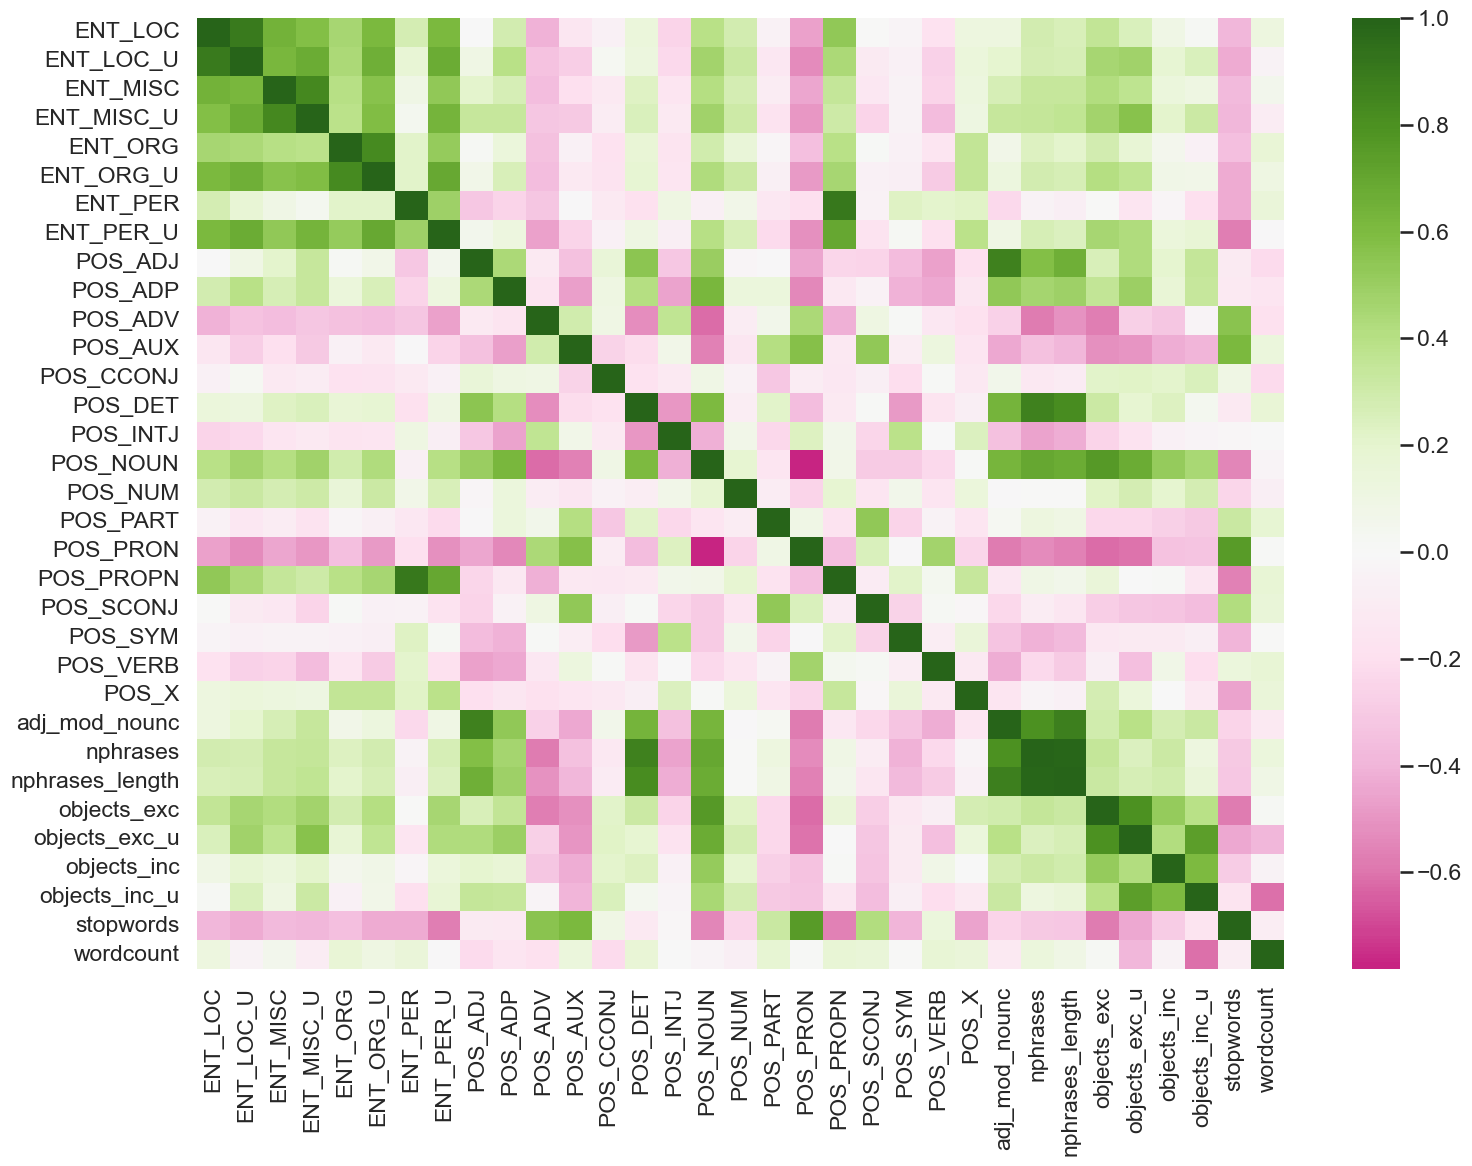

In [33]:
fig = plt.figure(figsize=(16,12))
sns.heatmap(
    properties.corr(), 
    center=0, 
    cmap='PiYG',
    xticklabels=1,
    yticklabels=1
)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'properties_correlations.png'), dpi=300)
plt.show()

In [34]:
# correlation values for plot above
# examine specific correlations, if desired
pair = ('objects_exc_u', 'POS_NOUN')
print(f"Correlation for {pair}: {properties.corr().loc[pair]}")

Correlation for ('objects_exc_u', 'POS_NOUN'): 0.67455663324282


### NLP features over time

Plot the level of each NLP feature over time in the full corpus. See the `figures` directory for individual, full-size plots.

In [35]:
# join and group data
nlp_plot_data = metadata[['year']].join(properties).groupby('year').mean()

# save full-size figures to disk
for name in nlp_plot_data.columns:
    sns.scatterplot(
        x='year',
        y=name,
        data=nlp_plot_data
    )
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"properties_over_time_{name}.png"), dpi=300)
    plt.close()

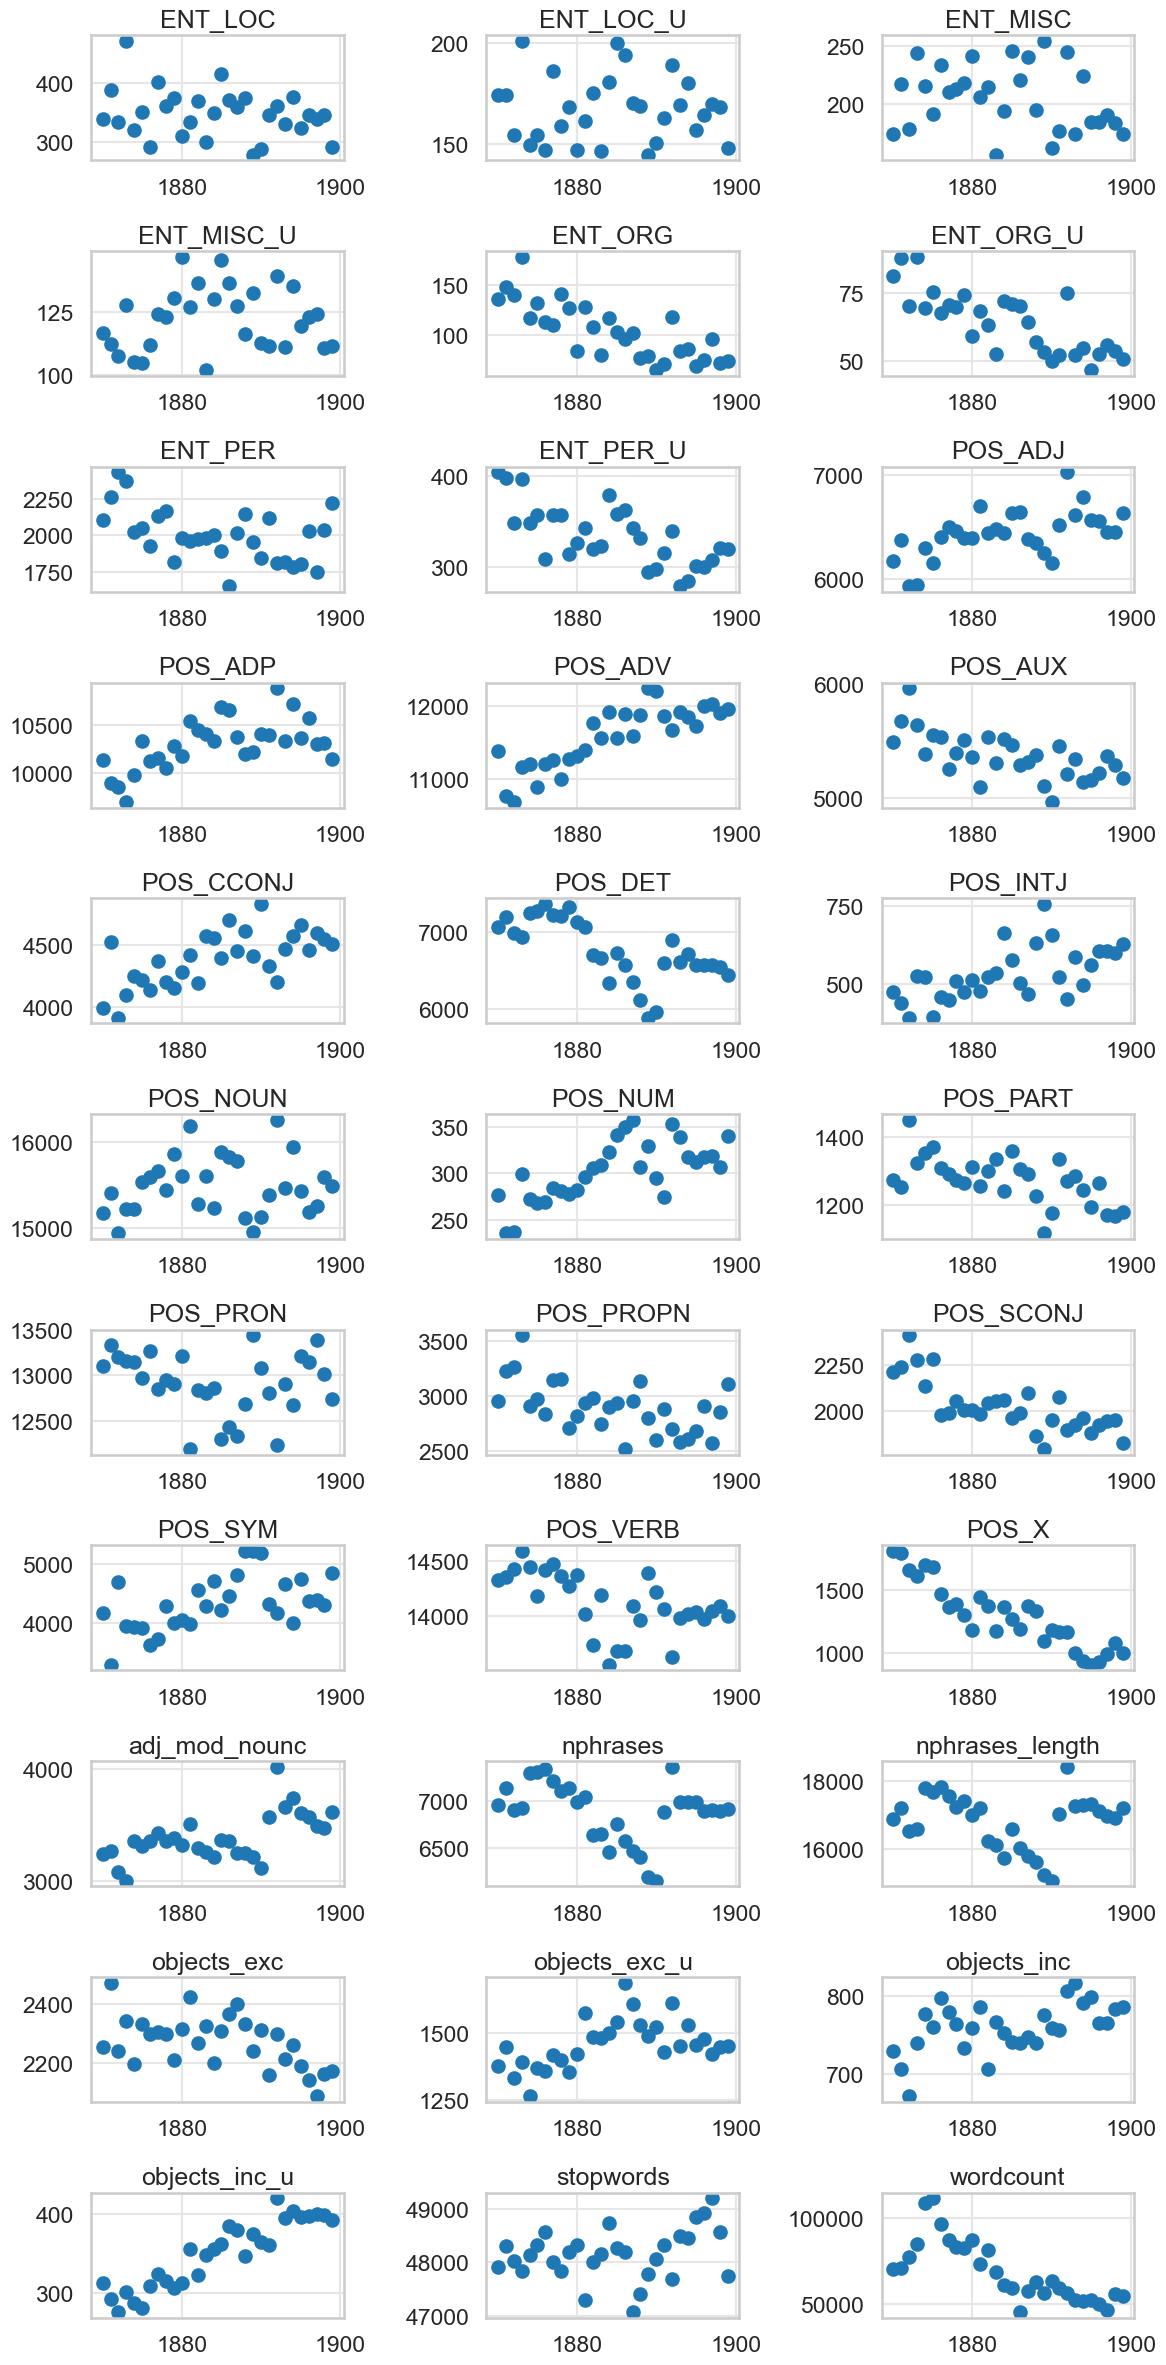

In [36]:
# small-multiples version
fig, ax = plt.subplots(nrows=11, ncols=3, figsize=(12,24))
ax = ax.ravel()
for i, name in enumerate(nlp_plot_data.columns):
    ax[i].scatter(
        nlp_plot_data.index,
        nlp_plot_data[name]
    )
    ax[i].set_title(name)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"properties_over_time_all.png"), dpi=300)
plt.show()

## NLP-based classifier

In [37]:
# examine accuracy for varying number of features
properties_z_with_labels = properties_z.loc[labels.index]
selector = SelectKBest(k='all') # score f_classif by default
best_features = selector.fit_transform(X=properties_z_with_labels, y=labels['realism'])

all_properties = selector.get_feature_names_out()
all_scores = np.log10(selector.pvalues_[selector.get_support()])
all_X = best_features
all_df = pd.DataFrame(
    all_X,
    index=labeled_texts.index,
    columns=all_properties
)
all_df['gold_label'] = labeled_texts['realism']
all_g = all_df.groupby('gold_label')

cv = cross_val_score(LogisticRegression(), all_X, labeled_texts['realism'], cv=3)
print(f"Cross-validated accuracy:\t{round(np.mean(cv), 3)}\t{np.round(cv, 3)}")

Cross-validated accuracy:	0.93	[0.9   1.    0.889]


Note that we've just done better building a classifier from NLP features than from token features above. This might be important? Certainly less prone to overfitting, and we might have expected that stylistic features would be better predictors of realism than would be the specific subject matter tied to word counts?

In [38]:
# train a model on NLP features and use it to predict reaism class of all texts in the corpus
model_nlp = LogisticRegression().fit(properties_z_with_labels, labeled_texts['realism'])
y_pred_nlp = model_nlp.predict(properties_z)
y_pred_nlp_proba = model_nlp.predict_proba(properties_z)

## Realism associations of NLP features

### Feature importance via linear *f* score

Just examining the training data here. Not yet comparing to model outputs.

In [39]:
def get_gold_class_for_feature(g, name):
    '''
    Take a Pandas df grouped by label and a column name.
    Return the label of the class for which the mean value in gthe column is higher.
    '''
    return g[name].mean().idxmax()

# display most distinctive features
print("\nMost distinctive features (alphabetical):")
longest_word = len(max(all_properties, key=len))
print('Token       log_10(p) Realist?')
print('------------------------------')
for i in range(len(all_properties)):
    print(f'{all_properties[i]: <{longest_word}} {round(all_scores[i], 1)}',
          '    ',
          get_gold_class_for_feature(all_g, all_properties[i])
         )

print('\nMost distinctive features (importance by log_10(p)):')
print('log_10(p) Token        Realist?')
print('------------------------------')

true_realism_labels_per_nlp_feature = []
nlp_by_importance = []

for i in np.argsort(all_scores):
    token = all_properties[i]
    nlp_by_importance.append(token)
    true_label = get_gold_class_for_feature(all_g, all_properties[i])
    true_realism_labels_per_nlp_feature.append(true_label)
    print(round(all_scores[i], 1),
          '    ',
          f'{token: <{longest_word+1}}',
          true_label
         )
    
print(f"\nNote: Significance at the p < 0.05 level implies a log_10(p) more negative than {np.log10(0.05)}")


Most distinctive features (alphabetical):
Token       log_10(p) Realist?
------------------------------
ENT_LOC         -1.4      n
ENT_LOC_U       -0.6      n
ENT_MISC        -0.3      n
ENT_MISC_U      -0.8      y
ENT_ORG         -1.0      n
ENT_ORG_U       -1.0      n
ENT_PER         -0.0      y
ENT_PER_U       -0.0      y
POS_ADJ         -1.2      y
POS_ADP         -0.7      y
POS_ADV         -2.8      y
POS_AUX         -1.0      n
POS_CCONJ       -1.5      y
POS_DET         -3.0      n
POS_INTJ        -0.8      y
POS_NOUN        -0.2      n
POS_NUM         -0.1      y
POS_PART        -3.5      n
POS_PRON        -0.3      n
POS_PROPN       -0.4      n
POS_SCONJ       -1.0      n
POS_SYM         -1.1      y
POS_VERB        -2.8      n
POS_X           -0.2      y
adj_mod_nounc   -0.0      y
nphrases        -2.6      n
nphrases_length -2.0      n
objects_exc     -0.0      n
objects_exc_u   -2.9      y
objects_inc     -1.4      n
objects_inc_u   -3.0      y
stopwords       -0.1      n

### Alternative feature importance: SHAP

A different, game-theoretic approach to feature importance for the NLP features.

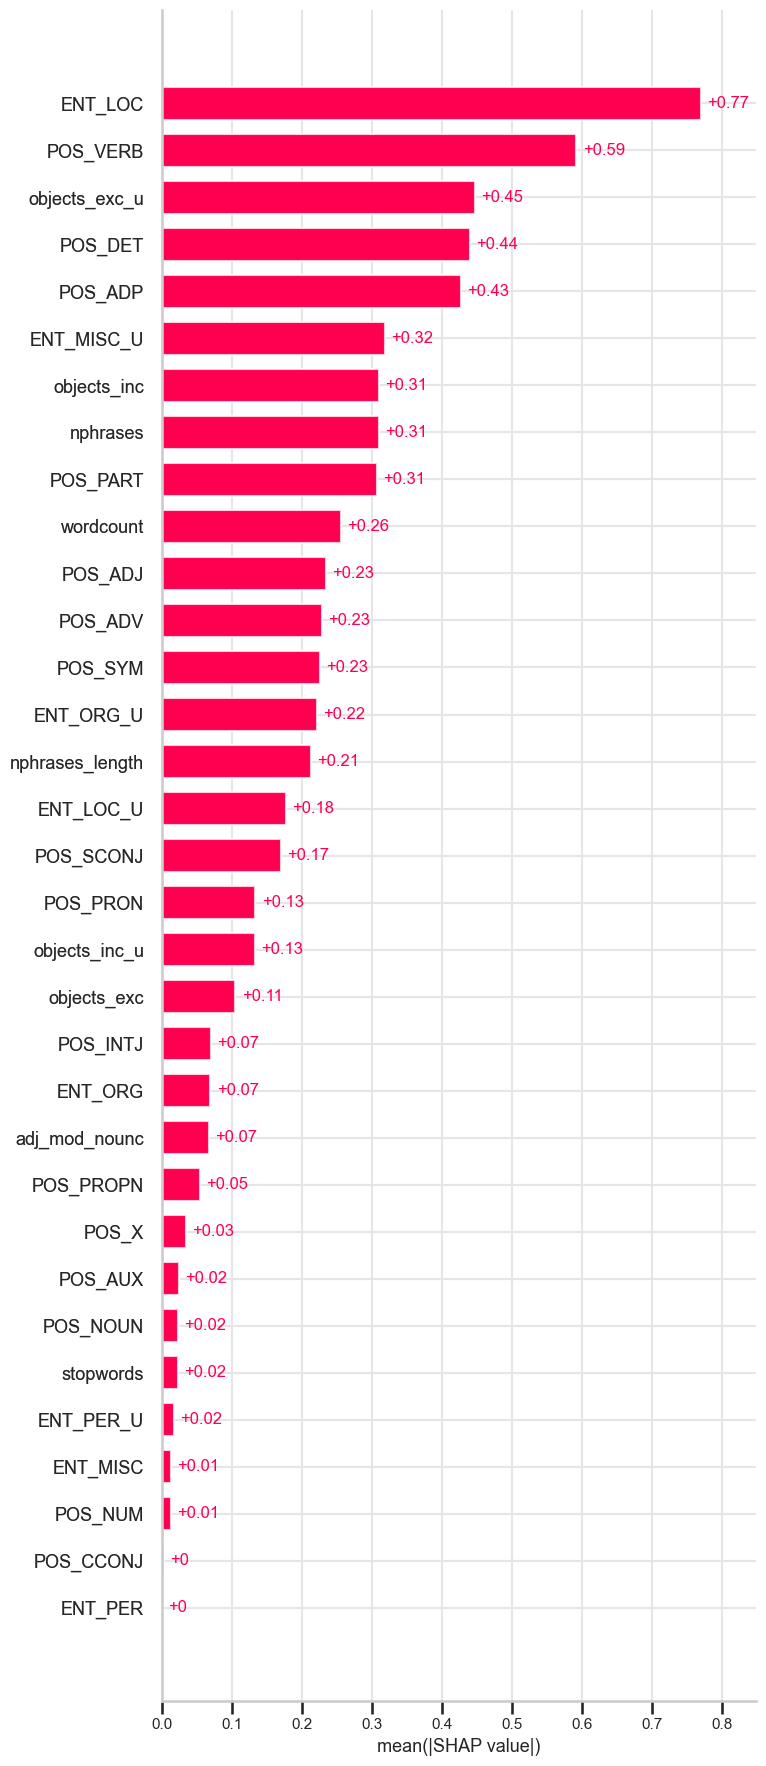

In [40]:
model = model_nlp # fitted above
X_shap = properties_z_with_labels # created above

background = shap.maskers.Independent(X_shap, max_samples=1000)
def model_log_odds(x):
    p = model.predict_log_proba(x)
    return p[:,1] - p[:,0]
explainer = shap.Explainer(model_log_odds, background)
shap_values = explainer(X_shap)

fig = plt.figure(figsize=figsize_std)
shap.plots.bar(shap_values, max_display=X_shap.shape[1], show=False)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'feature_importance_nlp_shap.png'), dpi=300)
plt.show()

**Note on interpreting SHAP values:** The numbers above are the mean absolute contribution of each feature to the log-odds ratio of the realism prediction. So, that's the difference in the log-odds probability of belonging to the realism class per standard deviation change in the value of the feature.

A change from 50:50 to 60:40 predicted probability of realism is a log-odds change of about 0.4 =`abs(np.log((50/50)/(60/40)))`. A change from 80:20 to 90:10 = 0.8.

It's not hard for a book to have features that are several standard deviations away from the mean, hence to see single feature contributions to the log odds ratio of 2 or more, at least for the most important features. That magnitude of change would imply moving from 50:50 to roughly 90:10 probability.

By the time we're down to low-importance features (with SHAP scores below, say, 0.1 or 0.2), it's unlikely that those features will make much of a difference to the model output.

# Examine NLP features in the full corpus with classification

We have two models of realsim, one based on token features (more about content and subject matter), the other on NLP features (more about form and style). 

We want to use the token-based classifier to group texts in the corpus (into predicted realist/nonrealist classes), then see how our NLP features varry between those classes.

We will first compare the predictive outputs of the two models to see where they disagree and where they are less confident in their predictions.

## Compare model outputs

In [41]:
# get model predictions and probabilities as dataframe

predictions_nlp = pd.DataFrame(
    {'realism_nlp':y_pred_nlp,
     'realism_nlp_probability':y_pred_nlp_proba[:,1]
    },
    index=properties_z.index
)

predictions = pd.DataFrame(
    {'realism_tokens':y_pred,
     'realism_tokens_probability':y_pred_proba[:,1]
    },
    index=corpus.index
)

predictions = predictions.join(predictions_nlp)

# join predictions with metadata
predictions = predictions.join(metadata)
predictions['disagreement_proba'] = predictions['realism_tokens_probability'] - predictions['realism_nlp_probability']

### Probabilities by class

In [42]:
# mean predictive probability by class for each model
print("Average predicted probability in token-based model")
print(predictions.groupby('realism_tokens')['realism_tokens_probability'].mean())
print("Value counts")
print(predictions.realism_tokens.value_counts())

print("\nAverage predicted probability in NLP-based model")
print(predictions.groupby('realism_nlp')['realism_nlp_probability'].mean())
print("Value counts")
print(predictions_nlp.realism_nlp.value_counts())

Average predicted probability in token-based model
realism_tokens
n    0.469335
y    0.541554
Name: realism_tokens_probability, dtype: float64
Value counts
y    562
n    277
Name: realism_tokens, dtype: int64

Average predicted probability in NLP-based model
realism_nlp
n    0.165837
y    0.866876
Name: realism_nlp_probability, dtype: float64
Value counts
y    592
n    247
Name: realism_nlp, dtype: int64


Note that the NLP-based model is generally more confident in its predictions, because it uses fewer features.

### Agreement and disagreement

In [43]:
# agreements
agree = predictions.loc[predictions.realism_tokens==predictions.realism_nlp]
print(f"Volumes with model agreement: {len(agree)} of {len(predictions)} = {100*len(agree)/len(predictions):.1f}%")

Volumes with model agreement: 639 of 839 = 76.2%


In [44]:
# large disagreements
large_level = 0.49
strong_disgreements = predictions.loc[abs(predictions['disagreement_proba'])>large_level]
print(f"Volumes with large (>{large_level}) model disagreements: {len(strong_disgreements)}")

Volumes with large (>0.49) model disagreements: 19


In [45]:
# disagreements (tokens say YES, nlp NO)
print("Volumes predicted realist by token-based model, but non-realist by NLP-based model")
display_columns = ['firstname', 'surname', 'title', 'subtitle', 'year', 'disagreement_proba']

disagree_yn = predictions.loc[
    (predictions.realism_tokens=='y') & 
    (predictions.realism_nlp=='n'), display_columns
]
print(f"  ### {len(disagree_yn)} records ordered by magnitude of disagreement ###") 
display(
    disagree_yn.sort_values(
    by='disagreement_proba',
    ascending=False
    ).head(20),
)

Volumes predicted realist by token-based model, but non-realist by NLP-based model
  ### 85 records ordered by magnitude of disagreement ###


,firstname,surname,title,subtitle,year,disagreement_proba
1883_Feddersen_EtAegteskab,Benjamin,Feddersen,Et Ægteskab,Roman,1883,0.546731
1878_Barner_CharlotteAmalie,Conradine,Barner,Charlotte Amalie,Prindsesse af Danmark. Et historisk Livsbillede,1878,0.541436
1888_Gioerup_SortePloug,Michael,Giørup,Sorte Ploug,Historisk Fortælling,1888,0.501358
1874_Barner_Jonskirken,Conradine,Barner,Jonskirken,Romantisk Skildring fra det attende Aarhundrede,1874,0.495026
1899_Hagerup_DenGamleKaempehoej,Hans Eiler Hensemann,Hagerup,Den gamle Kæmpehøj,Fortælling,1899,0.492474
1888_Gioerup_DerovreFra,Michael,Giørup,Derovre fra,Fortælling fra den anden slesvigske Krig,1888,0.492057
1882_VR_HalvbroedreneEllerKjaerlighedensMagt,NaN,NaN,Halvbrødrene eller Kjærlighedens Magt,Historisk Roman,1882,0.486907
1897_Gioerup_DronningOgHirdmand,Michael,Giørup,Dronning og Hirdmand,Historisk Fortælling,1897,0.477302
1895_EwaldHF_LeonoraKristina,H.F.,Ewald,Leonora Kristina,Billeder af en Kongedatters Liv,1895,0.473701
1899_EwaldHF_DanielRantzow,H.F.,Ewald,Daniel Rantzow,Billeder fra den nordiske Syvaarskrig,1899,0.471580


In [46]:
#disagreements (tokens say NO, nlp YES)
print("Volumes predicted nonrealist by token-based model, but realist by NLP-based model")

disagree_ny = predictions.loc[
    (predictions.realism_tokens=='n') & 
    (predictions.realism_nlp=='y'), display_columns
]
print(f"  ### {len(disagree_ny)} records ordered by magnitude of disagreement ###") 
display(
    disagree_ny.sort_values(
    by='disagreement_proba',
    ascending=True
    ).head(20),
)

Volumes predicted nonrealist by token-based model, but realist by NLP-based model
  ### 115 records ordered by magnitude of disagreement ###


,firstname,surname,title,subtitle,year,disagreement_proba
1871_Wolle_FraMinFoerstePraxis,Emil,Wolle,Fra min første Praxis,Fortælling,1871,-0.527702
1892_Muusmann_PaaSolsiden,Carl,Muusmann,Paa Solsiden,NaN,1892,-0.525038
1877_Lange_EtSymposion,Thomas,Lange,Et Symposion,Fortælling,1877,-0.514689
1888_Rink_KoloniIdyllerFraGroenland,Signe,Rink,Koloni-Idyller fra Grønland,NaN,1888,-0.513841
1894_Gjellerup_PastorMors,Karl,Gjellerup,Pastor Mors,En underlig Historie,1894,-0.502681
1897_Gjellerup_Konvolutten,Karl,Gjellerup,Konvolutten,En graphologisk Studie,1897,-0.500909
1870_LevetzowV_ModersArv,Vilhelmine Louise von,Levetzow,Moders Arv,NaN,1870,-0.500465
1874_Incognito_VenusTempel,Peter,Incognito,Venus-Tempel,Reist til Ære for Venus og Bacchus,1874,-0.498308
1886_Bille_Skoledrenge,Carl Steen Andersen,Bille,Skoledrenge,NaN,1886,-0.494896
1879_Rovsing_EnsomtLiv,K.,Rovsing,Ensomt Liv,NaN,1879,-0.488933


## Statistical testing

Compare object frequencies in modeled realist vs. nonnonrealist volumes in the full corpus. But see output of the mixed model, below, for the best version of this.

In [47]:
# select data to analyze
model_types = ['realism_tokens', 'realism_nlp']
object_types = ['objects_exc', 'objects_exc_u', 'objects_inc', 'objects_inc_u']
object_model_data = predictions[model_types].join(properties[object_types])

In [48]:
# statistic to test (difference in means between groups)
def means_diff(x, y):
    return np.mean(x) - np.mean(y)

for model_type in model_types:
    for object_type in object_types:
        data_groups = []
        group_labels = []
        for label, group in object_model_data[[object_type, model_type]].groupby(model_type):
            group_labels.append(label)
            data_groups.append(group[object_type].to_numpy())
        perm_test_result = scipy.stats.permutation_test(
            data=data_groups, 
            statistic=means_diff,
            alternative='two-sided'
        )
        print(f"{model_type},\t{object_type}, p-value:\t{perm_test_result.pvalue}")

realism_tokens,	objects_exc, p-value:	0.0006
realism_tokens,	objects_exc_u, p-value:	0.0004
realism_tokens,	objects_inc, p-value:	0.2904
realism_tokens,	objects_inc_u, p-value:	0.0002
realism_nlp,	objects_exc, p-value:	0.0022
realism_nlp,	objects_exc_u, p-value:	0.0002
realism_nlp,	objects_inc, p-value:	0.0094
realism_nlp,	objects_inc_u, p-value:	0.0002


# Mixed model

Let's try building a model that uses the c. 50 most informative token features and all the NLP features *except* the object ones. This should be high-performing and allows us to examine object data without direct circularity.

## Token feature importance vs. expert expectation

Compare label associations of token features to expert predictions.

In [49]:
# read expert predictions from disk
features_expert = pd.read_excel(
    feature_pred_file,
    sheet_name='Ark1',
    usecols=['token', 'Guess (realism?  y/n)'],
    na_values='Ø'
).dropna()
features_expert.columns = ['token', 'realism_expert']
features_expert.set_index('token', inplace=True)

# create dataframe of true class associations for token features
features_true = pd.DataFrame(
    true_realism_labels_per_token_feature,
    index=tokens_by_importance,
    columns=['realism_true']
)

# join data
features_compare = features_true.join(features_expert).dropna()
features_compare['error'] = features_compare['realism_true'] != features_compare['realism_expert']

# restrict token features to those present in both sets
#  some hand-labeled tokens excluded by new vectorization settings
token_feature_names = list(set(vectorizer.get_feature_names_out()).intersection(set(features_compare.index)))
features_compare = features_compare.loc[token_feature_names]

def label_error(x):
    if x:
        return('***')
    return(' ')

features_compare['flag'] = features_compare['error'].apply(label_error)
print(features_compare.sort_index()[['realism_true', 'realism_expert', 'flag']])
print(f"\nMisprediction rate: {100*round(sum(features_compare['error'])/len(features_compare), 3)}% ({sum(features_compare['error'])}/{len(features_compare)})")
print(f"Features associated with nonrealism: {sum(features_compare['realism_true']=='n')} ({sum(features_compare['realism_true']=='n')/len(features_compare)*100:.1f}%)")

            realism_true realism_expert flag
altid                  y              y     
bemærket               n              n     
berøvet                n              n     
besiddelse             n              n     
besluttede             n              n     
betale                 n              y  ***
bringe                 n              n     
dertil                 n              n     
faae                   n              n     
fint                   y              y     
foer                   n              n     
forlade                n              n     
forlod                 n              n     
fortælling             n              n     
frygte                 n              n     
ført                   n              n     
gaaer                  n              n     
helt                   y              y     
hævne                  n              n     
leilighed              n              n     
lykkedes               n              n     
mit       

## Build the model

In [50]:
# select top token features
X_mixed = pd.DataFrame(
    data=StandardScaler().fit_transform(X.toarray()),
    columns=vectorizer.get_feature_names_out(),
    index=corpus.index
)
X_mixed = X_mixed[token_feature_names] # token_feature_names defined in previous code cell

# select nlp features
X_nlp = pd.DataFrame(
    data=properties_z[list(set(properties_z.columns).difference(object_types))]
)

# join feature sets
X_mixed = X_mixed.join(X_nlp)

In [51]:
# select training data
X_mixed_train = X_mixed.loc[labels.index]
y_mixed_train = labels['realism']

In [52]:
# check performance under cross validation
cv_mixed = cross_val_score(LogisticRegression(), X_mixed_train, y_mixed_train, cv=3)
print(f"Cross-validated accuracy of the mixed model: {np.mean(cv_mixed):.3f}")

Cross-validated accuracy of the mixed model: 1.000


That's pretty good performance!

In [53]:
# fit mixed model and predict classes
model_mixed = LogisticRegression(max_iter=10000)
model_mixed.fit(X_mixed_train, y_mixed_train)
y_mixed_pred = model_mixed.predict(X_mixed)
y_mixed_proba = model_mixed.predict_proba(X_mixed)

## Realism over time

In [54]:
y_mixed_predictions = pd.DataFrame(
    y_mixed_pred,
    columns=['realism_mixed'],
    index=X_mixed.index
)
y_mixed_predictions['realism_mixed_probability'] = y_mixed_proba[:,1]
y_mixed_predictions = y_mixed_predictions.join(metadata['year'])

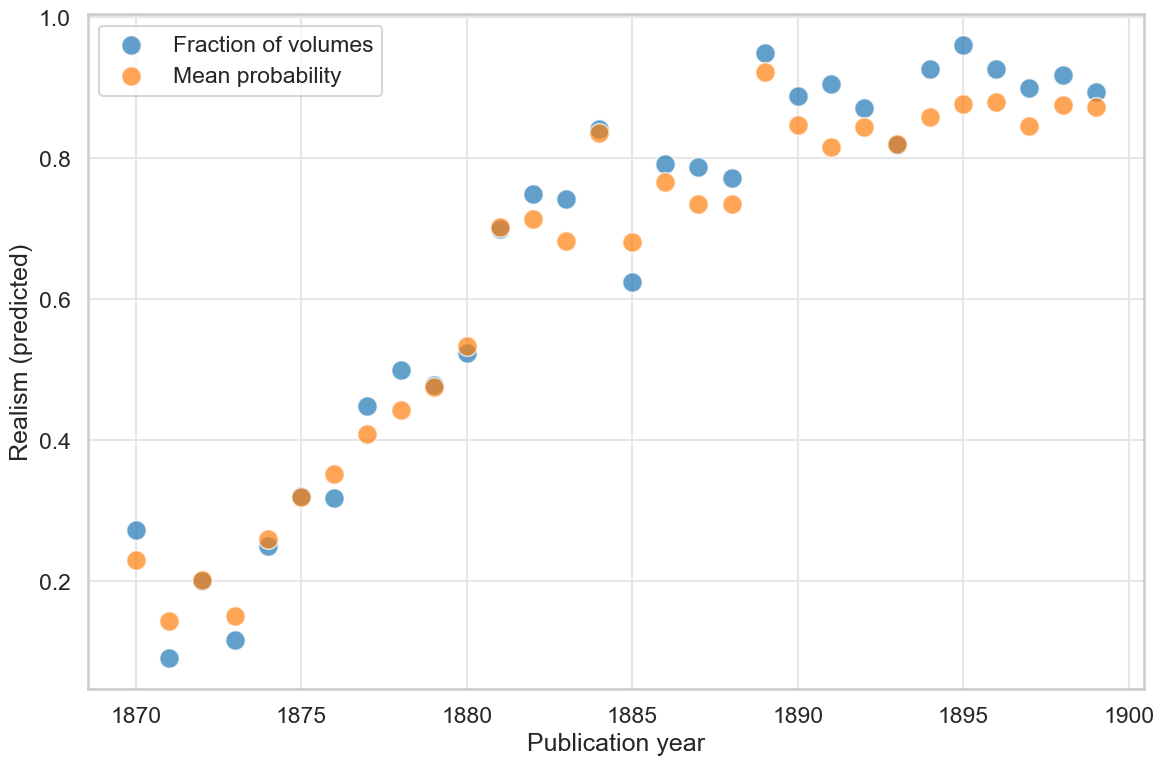

In [55]:
# plot realism fraction by year
years = []
realism_fraction = []
realism_mean_proba = []

for name, group in y_mixed_predictions.groupby(['year']):
    years.append(int(name))
    realism_fraction.append(sum(group['realism_mixed']=='y')/len(group))
    realism_mean_proba.append(group['realism_mixed_probability'].mean())

sns.scatterplot(x=years, y=realism_fraction, s=200, alpha=0.7, label='Fraction of volumes')
sns.scatterplot(x=years, y=realism_mean_proba, s=200, alpha=0.7, label='Mean probability')
plt.xlabel('Publication year')
plt.ylabel('Realism (predicted)')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'realism_pred_by_year_mixed.png'), dpi=300)
plt.show()

## Top volumes

Most and least realist volumes according to the mixed features model.

In [56]:
# add mixed model outputs to predictions data
predictions = predictions.join(y_mixed_predictions[['realism_mixed', 'realism_mixed_probability']])
predictions['realism_rank'] = predictions['realism_mixed_probability'].rank(ascending=False)

In [57]:
# write predictions for disk for outside examination
predictions.to_csv(os.path.join(res_dir, 'predictions.csv'))

### Realist

In [58]:
display_columns = ['firstname', 'surname', 'title', 'subtitle', 'year', 'realism_mixed_probability']
predictions.sort_values(by='realism_rank', ascending=True)[display_columns].head(30)

,firstname,surname,title,subtitle,year,realism_mixed_probability
1888_Vedel_Stavnsbaand,Valdemar,Vedel,Stavnsbaand,Fortælling,1888,0.999573
1883_Pontoppidan_SandingeMenighed,Henrik,Pontoppidan,Sandinge Menighed,En Fortælling,1883,0.999138
1890_MoellerN_Haendelser,Niels,Møller,Hændelser,NaN,1890,0.999108
1898_Bon_StoltenbergOgAndreSvende,Fridtjof,Bon,Stoltenberg og andre Svende,NaN,1898,0.998739
1897_Alsted_Ly,Peter,Alsted,Ly,NaN,1897,0.998260
1893_Brummer_EnKamp,Therese,Brummer,En Kamp,Familieinteriør,1893,0.998216
1894_PetersenL_MellemKlitter,Lauritz,Petersen,Mellem Klitter,Roman,1894,0.998197
1886_Winterhjelm_Naturalisterne,Kristian,Winterhjelm,Naturalisterne,En Sommerskitse fra Stockholms Skjærgaard,1886,0.998147
1895_MoellerN_Koglerier,Niels,Møller,Koglerier,NaN,1895,0.998129
1896_Nilssen_Nemesis,Jappe,Nilssen,Nemesis,Fortælling,1896,0.997995


#### Herman Bang

In [59]:
predictions.sort_values(
    by='realism_rank', ascending=True
).loc[
    predictions.surname=='Bang', display_columns + ['realism_rank']
].join(properties_z[['POS_ADJ']])

,firstname,surname,title,subtitle,year,realism_mixed_probability,realism_rank,POS_ADJ
1898_BangH_DetHvideHus,Herman,Bang,Det hvide Hus,NaN,1898,0.994631,60.0,-0.893456
1880_Bang_HaabloeseSlaegter,Herman,Bang,Haabløse Slægter,NaN,1880,0.994336,65.0,-1.099814
1883_BangH_Praester,Herman,Bang,Præster,NaN,1883,0.992220,106.0,-0.881299
1899_Bang_LivOgDoed,Herman,Bang,Liv og Død,NaN,1899,0.991111,128.0,-1.480395
1887_BangH_Stuk,Herman,Bang,Stuk,NaN,1887,0.988234,190.0,-0.832057
1886_BangH_StilleEksistenser,Herman,Bang,Stille Eksistenser,Fire Livsbilleder,1886,0.987140,204.0,-1.243483
1883_BangH_Faedra,Herman,Bang,Fædra,Brudstykker af et Livs Historie,1883,0.985252,221.0,-1.328294
1889_BangH_Tine,Herman,Bang,Tine,NaN,1889,0.958569,359.0,-1.942504


#### J.P. Jacobsen

Compare adjective frequency to Bang.

In [60]:
predictions.sort_values(
    by='realism_rank', ascending=True
).loc[
    (predictions.surname=='Jacobsen') &
    (predictions.firstname=='J.P.'), 
    display_columns + ['realism_rank']
].join(properties_z[['POS_ADJ']])

,firstname,surname,title,subtitle,year,realism_mixed_probability,realism_rank,POS_ADJ
1880_JacobsenJP_NielsLyhne,J.P.,Jacobsen,Niels Lyhne,Roman,1880,0.990326,143.0,1.561269
1876_JacobsenJP_FruMarieGrubbe,J.P.,Jacobsen,Fru Marie Grubbe,Interieurer fra det syttende Aarhundrede,1876,0.915856,431.0,1.046061


#### Amalie Skram

We quote her story "Madam Høiers Leiefolk" in the essay as an example of realism. Her books all rank pretty highly in predicted realism.

In [61]:
predictions.sort_values(
    by='realism_rank', ascending=True
).loc[
    (predictions.surname=='Skram') &
    (predictions.firstname=='Amalie'), 
    display_columns + ['realism_rank']]

,firstname,surname,title,subtitle,year,realism_mixed_probability,realism_rank
1888_SkramA_Lucie,Amalie,Skram,Lucie,Roman,1888,0.995575,47.0
1895_SkramA_PaaSctJoergen,Amalie,Skram,På Sct. Jørgen,NaN,1895,0.994053,73.0
1892_Skram_Forraadt,Amalie,Skram,Forraadt,NaN,1892,0.994025,74.0
1895_SkramA_ProfessorHieronimus,Amalie,Skram,Professor Hieronimus,NaN,1895,0.993484,83.0
1890_SkramA_SGMyreHellemyrsfolket,Amalie,Skram,S. G. Myre. Hellemyrsfolket,Roman,1890,0.993047,91.0
1898_SkramA_Afkom,Amalie,Skram,Afkom,Roman,1898,0.991372,125.0
1887_SkramA_ToVennerHellemyrsfolket,Amalie,Skram,To Venner. Hellemyrsfolket,Fortælling,1887,0.988824,179.0
1887_SkramA_SjurGabrielHellemyrsfolket,Amalie,Skram,Sjur Gabriel. Hellemyrsfolket,Fortælling,1887,0.973032,306.0


#### Sophus Claussen

Symbolist, maybe low realism?

In [62]:
predictions.sort_values(
    by='realism_rank', ascending=True
).loc[
    (predictions.surname=='Claussen') &
    (predictions.firstname=='Sophus'), 
    display_columns + ['realism_rank']]

,firstname,surname,title,subtitle,year,realism_mixed_probability,realism_rank
1895_Claussen_Kitty,Sophus,Claussen,Kitty,Lyrisk Fortælling,1895,0.990709,136.0
1894_ClaussenS_UngeBander,Sophus,Claussen,Unge Bander,Fortælling fra en Købstad,1894,0.989561,163.0
1896_ClaussenS_AntoniusiParis,Sophus,Claussen,Antonius i Paris,Hans Optegnelser,1896,0.944611,394.0
1896_ClaussebS_Valfart,Sophus,Claussen,Valfart,NaN,1896,0.918488,428.0


### Nonrealist

In [63]:
predictions.sort_values(by='realism_rank', ascending=False)[display_columns].head(30)

,firstname,surname,title,subtitle,year,realism_mixed_probability
1870_Gundersen_EnPolitimandsErindringer,William K.,Gundersen,En Politimands Erindringer,NaN,1870,0.000071
1878_SoerensenC_AltForFaedrelandet,Carl,Sørensen,Alt for Fædrelandet,Original historisk Roman med Portræter,1878,0.000079
1875_KofoedHansen_Livslaenker,Hans Peter,Kofoed-Hansen,Livslænker,En Fortælling,1875,0.000091
1876_Albertius_KlokkenIRosendalen_1,Claudius,Albertius,Klokken i Rosendalen,Original romantisk Fortælling,1876,0.000125
1875_Vende_LeonieEllerEnNatIMinerne_2,James,Vendé,Leonie eller En Nat i Minerne,Original romantisk Fortælling (grundet paa vir...,1875,0.000179
1874_Albertius_BjergmandensRing_2,Claudius,Albertius,Bjergmandens Ring 2,Original romantisk Fortælling,1874,0.000186
1875_SoerensenC_KjaerlighedVedHoffet,Carl,Sørensen,Kjærlighed ved Hoffet,Fædrelandshistorisk Skildring fra det attende ...,1875,0.000234
1876_LB_Taterkongen,NaN,NaN,Taterkongen,Original Fortælling,1876,0.000270
1872_Valdemar_KjaerlighedHaevnOgFrelse,NaN,NaN,"Kjærlighed, Hævn og Frelse",En original Fortælling,1872,0.000296
1871_L.F._Capercapitainen,NaN,NaN,Capercapitainen,Englænderne i Kjøbenhavn 1801 og Kjøbenhavns B...,1871,0.000354


## Statistical tests

Check whether object density varies significantly between realist and non-realist texts, as predicted by the mixed model.

In [64]:
def effect_size(g1, g2, hedges=True):
    '''
    Calculate Cohen's d or Hedges's g (default) effect size
      For details, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/
    Takes two dataframes (typically, groups from a groupby operation)
      or numpy arrays, plus optional alternative
    Returns effect size as a float
    '''
    mean_diff = g1.mean() - g2.mean()
    pooled_std = np.sqrt(
            (
                ((len(g1)-1) * (g1.std()**2)) + 
                ((len(g2)-1) * (g2.std()**2))
            ) /
            (len(g1) + len(g2) - 2)
        )
    d = abs(mean_diff/pooled_std)
    if hedges:
        g = d * (1 - 3/(4*(len(g1)+len(g2))-9))
        return g
    else:
        return d

In [65]:
# assemble predictions and object data
objects_mixed_data = predictions[['realism_mixed']].join(properties[object_types])

print(f"{'metric': <16}{'real': <8}{'nonreal':<8}{'effect':<8}p-value")
print("===============================================")
for object_type in object_types:
    data_groups = []
    group_labels = []
    realism_means = []
    for label, group in objects_mixed_data[[object_type, 'realism_mixed']].groupby('realism_mixed'):
        group_labels.append(label)
        data_groups.append(group[object_type].to_numpy())
        realism_means.append(group[object_type].mean())
    perm_test_result = scipy.stats.permutation_test(
        data=data_groups, 
        statistic=means_diff,
        alternative='two-sided'
    )
    effect = effect_size(data_groups[0], data_groups[1])
    print(f"{object_type}\t{realism_means[1]:.1f}\t{realism_means[0]:.1f}\t{effect:.2f}\t{perm_test_result.pvalue}")

metric          real    nonreal effect  p-value
objects_exc	2221.8	2343.8	0.32	0.0002
objects_exc_u	1512.0	1358.5	0.46	0.0002
objects_inc	768.8	762.3	0.05	0.491
objects_inc_u	387.1	295.6	0.96	0.0002


### Note on effect size

Effect size is an estimate of how big (in relative terms) is the difference in a measured property between two groups. It tends to track (inversely) with *p*-value. That is, if an effect is unlikely to be due to chance (low *p* value), it has a large effect size.

We measure effect size using Hedges's tweak to Cohen's method. This is a modestly adjusted version of the difference in the means of the two groups, divided by the pooled standard deviation of all the observations in those groups.

There is a [standard interpretive key](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) to these effect sizes:

| Effect size  |  d  |
|---|---|
| Very small |  0.01  |
| Small |  0.20  |
| Medium |  0.50  |
| Large | 0.80  |
| Very large | 1.20  |
| Huge | 2.0  |

For details of the calculation, see code above and [Lakens (2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/).

## Group comparisons


Examine realism rates and feature values segmented by:

* Author gender
* Author nationality
* Publisher
* Book length (by word count)
* Price

I'll use *predicted probability* of realism as the measure of realism, since this allows us to treat realism as a continuous feature of each text, rather than a pure yes/no distinction.

Begin by creating new columns for easy faceting:

In [66]:
# length groups
predictions['length'] = 'short'
predictions.loc[properties['wordcount'].gt(properties.wordcount.median()), 'length'] = 'long'

# price groups
predictions['cost'] = np.nan
predictions.loc[predictions['price'] > predictions.price.median(), 'cost'] = 'expensive'
predictions.loc[predictions['price'] < predictions.price.median(), 'cost'] = 'cheap'

# publisher groups
main_publishers = set(['Gyldendal', 'Schubothe', 'Schou', 'Philipsen'])
predictions['publisher_big'] = 'other'
predictions.loc[predictions['publisher'].isin(main_publishers), 'publisher_big'] = 'main'

In [67]:
# define the groups and labels
groups_to_compare = {
    'gender':{
        'display':'Author gender',
        'levels':{
            'f':'Women',
            'm':'Men'}
    },
    'nationality':{
        'display':'Nationality',
        'levels':{
            'dk':'Danish',
            'no':'Norwegian'}
    },
    'length':{
        'display':'Length',
        'levels':{
            'short':'Shorter',
            'long':'Longer'}
    },
    'cost':{
        'display':'Price',
        'levels':{
            'cheap':'Less expensive',
            'expensive':'More expensive'}
    },
    'publisher_big':{
        'display':'Publisher',
        'levels':{
            'main':'"Big four"', 
            'other':'Other'}
    },
    'typeface':{
        'display':'Typeface',
        'levels':{
            'roman':'Roman',
            'gothic':'Gothic'}
    },
    'illustrations':{
        'display':'Illustrated',
        'levels':{
            'y':'Yes',
            'n':'No'}
    }
}

### Summary statistics by group

Some simple summary numbers for reference. Mostly, we can see here the exact means and number of books in each group.

In [68]:
for facet in groups_to_compare.keys():
    display(predictions[['realism_mixed_probability', facet]].groupby(facet).describe())

realism_mixed_probability                                          \
                           count      mean       std       min       25%   
gender                                                                     
f                          145.0  0.766045  0.311749  0.001279  0.611708   
m                          598.0  0.742880  0.352864  0.000079  0.584403   

                                      
             50%       75%       max  
gender                                
f       0.943309  0.987095  0.998216  
m       0.953708  0.988383  0.999573

realism_mixed_probability                                          \
                                count      mean       std       min       25%   
nationality                                                                     
dk                              627.0  0.705967  0.360466  0.000079  0.482119   
no                              122.0  0.947880  0.124892  0.129259  0.963398   

                                           
                  50%       75%       max  
nationality                                
dk           0.921752  0.984546  0.999573  
no           0.987222  0.992859  0.998147

realism_mixed_probability                                          \
                           count      mean       std       min       25%   
length                                                                     
long                       419.0  0.559761  0.419303  0.000071  0.057396   
short                      420.0  0.811803  0.292474  0.000472  0.773669   

                                      
             50%       75%       max  
length                                
long    0.696245  0.975234  0.998197  
short   0.964788  0.989787  0.999573

realism_mixed_probability                                          \
                              count      mean       std       min       25%   
cost                                                                          
cheap                         363.0  0.734967  0.344851  0.000071  0.556979   
expensive                     317.0  0.703537  0.378719  0.000091  0.402874   

                                         
                50%       75%       max  
cost                                     
cheap      0.938151  0.986810  0.999573  
expensive  0.946119  0.987313  0.998197

realism_mixed_probability                                \
                                  count      mean       std       min   
publisher_big                                                           
main                              338.0  0.843469  0.273622  0.000091   
other                             501.0  0.579650  0.408358  0.000071   

                                                       
                    25%       50%       75%       max  
publisher_big                                          
main           0.867382  0.972992  0.990279  0.999138  
other          0.075045  0.738487  0.979149  0.999573

realism_mixed_probability                                          \
                             count      mean       std       min       25%   
typeface                                                                     
gothic                       258.0  0.259654  0.325236  0.000071  0.011253   
roman                        579.0  0.876616  0.216630  0.003162  0.879346   

                                        
               50%       75%       max  
typeface                                
gothic    0.079774  0.484821  0.991508  
roman     0.975763  0.990254  0.999573

realism_mixed_probability                                \
                                  count      mean       std       min   
illustrations                                                           
n                                 729.0  0.684150  0.383154  0.000071   
y                                  94.0  0.680805  0.382872  0.000079   

                                                       
                    25%       50%       75%       max  
illustrations                                          
n              0.330766  0.927712  0.986921  0.999573  
y              0.373609  0.913861  0.984914  0.999138

### Statistical significance by group

Are the observed differences in realism rates between the groups statistically significant? See the notes on effect sizes and *p*-values above for interpretive guidance.

In [69]:
# calculate means, effect sizes, and permutation p-values per grouped metadata facet

target_col = 'realism_mixed_probability'
for facet in groups_to_compare.keys():
    data_groups = []
    group_labels = []
    for label, group in predictions[[facet, target_col]].groupby(facet):
        group_labels.append(label)
        data_groups.append(group[target_col])
    print(facet)
    print("=====")
    print(f"{group_labels[0]} mean: {data_groups[0].mean():.3f}")
    print(f"{group_labels[1]} mean: {data_groups[1].mean():.3f}")
    print(f"effect size: {effect_size(data_groups[0], data_groups[1], target_col):.2f}")
    perm_test_result = scipy.stats.permutation_test(
        data=data_groups, 
        statistic=means_diff,
        alternative='two-sided'
    )
    print(f"p-value: {perm_test_result.pvalue:.5f}")
    print()

gender
=====
f mean: 0.766
m mean: 0.743
effect size: 0.07
p-value: 0.47040

nationality
=====
dk mean: 0.706
no mean: 0.948
effect size: 0.72
p-value: 0.00020

length
=====
long mean: 0.560
short mean: 0.812
effect size: 0.70
p-value: 0.00020

cost
=====
cheap mean: 0.735
expensive mean: 0.704
effect size: 0.09
p-value: 0.27460

publisher_big
=====
main mean: 0.843
other mean: 0.580
effect size: 0.73
p-value: 0.00020

typeface
=====
gothic mean: 0.260
roman mean: 0.877
effect size: 2.42
p-value: 0.00020

illustrations
=====
n mean: 0.684
y mean: 0.681
effect size: 0.01
p-value: 0.92620



Predicted realism does not differ with or without illustrations. Drop `illustrations` from the list of facets to consider further.

In [70]:
del groups_to_compare['illustrations']

### Realism over time by facet and group

Plot changes in predicted realism over time by meatadata facet and group within that facet.

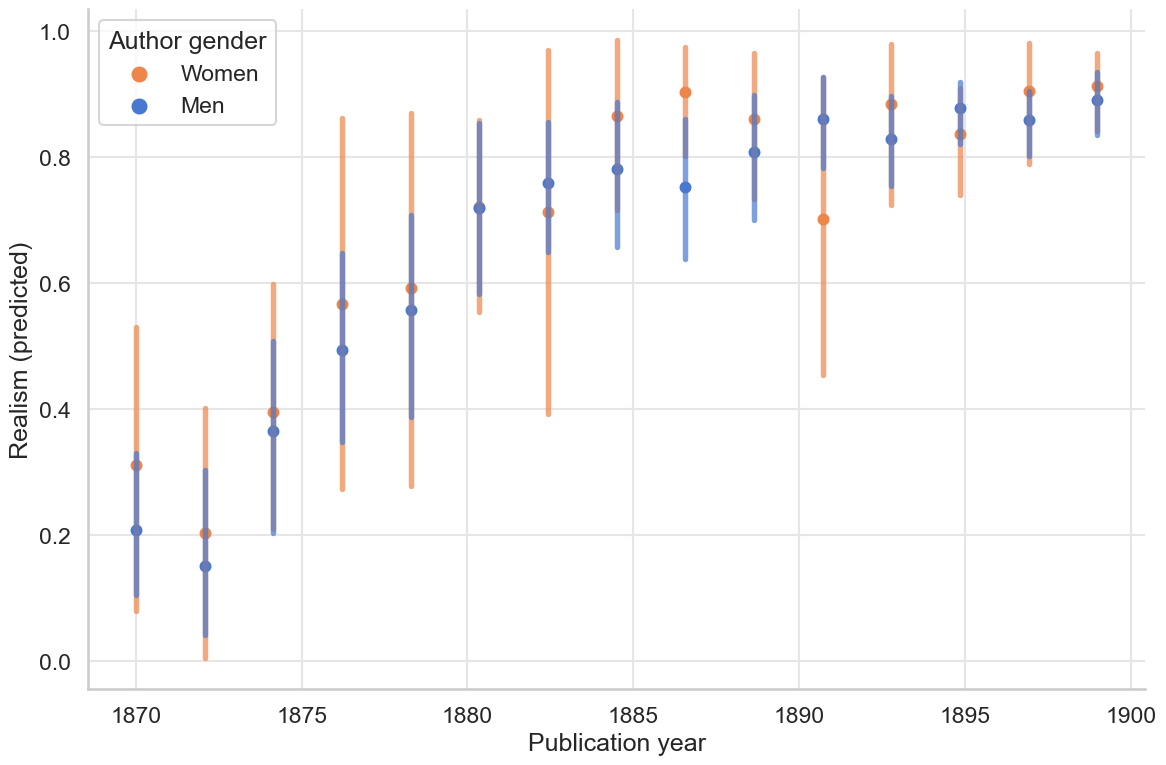

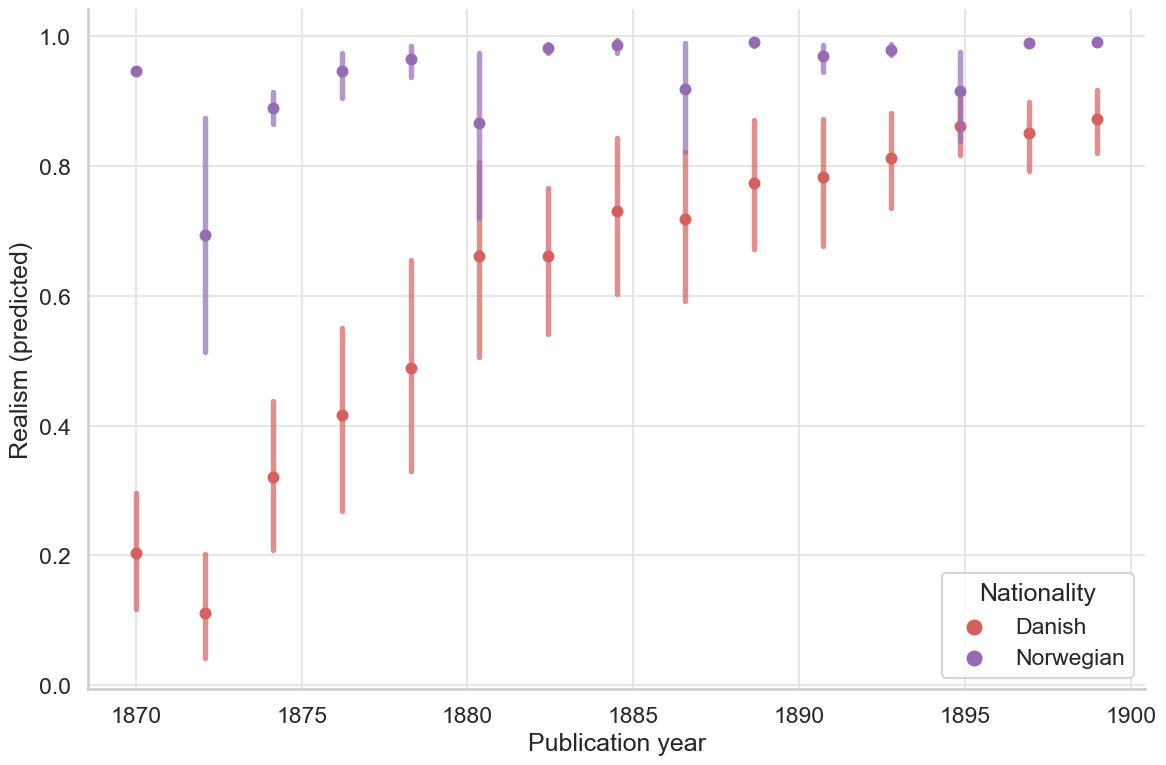

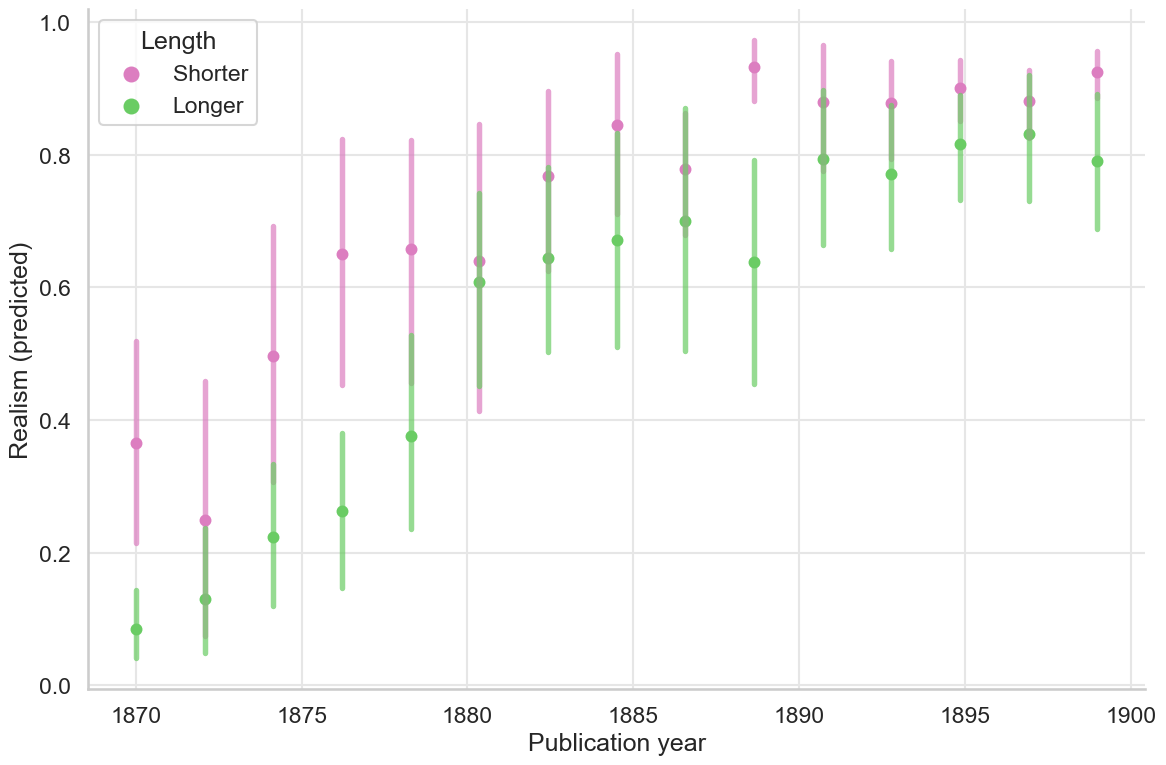

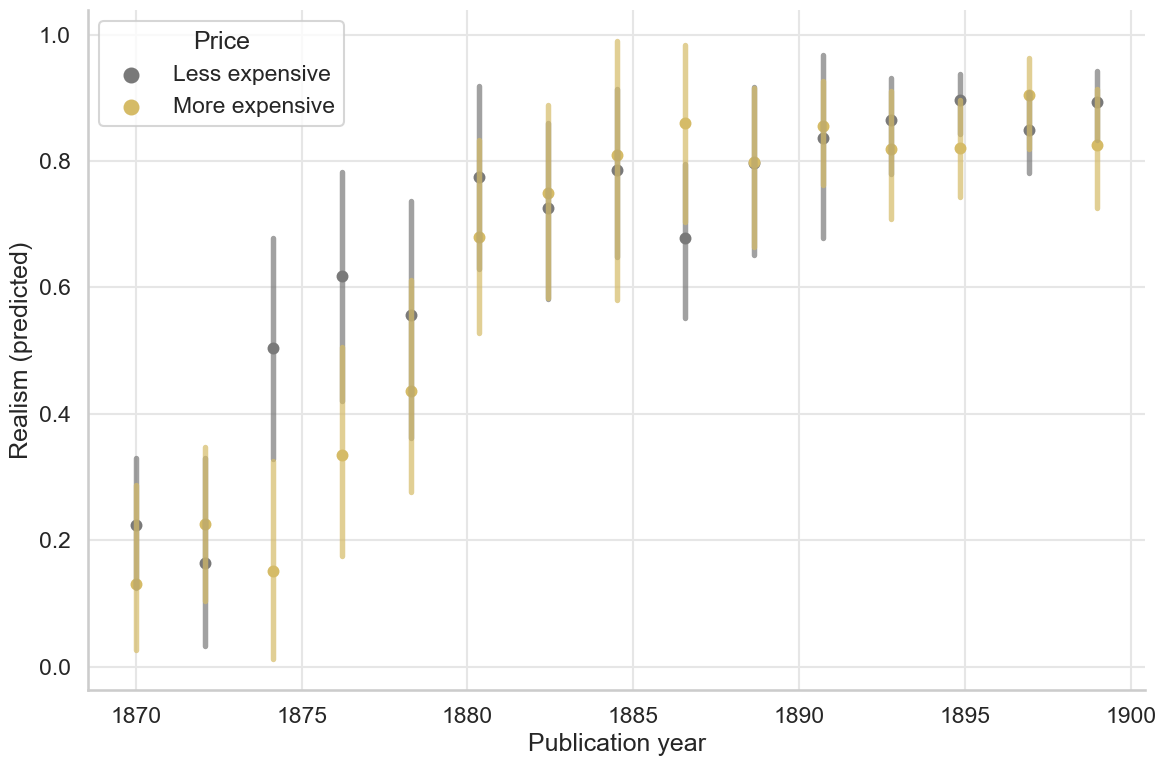

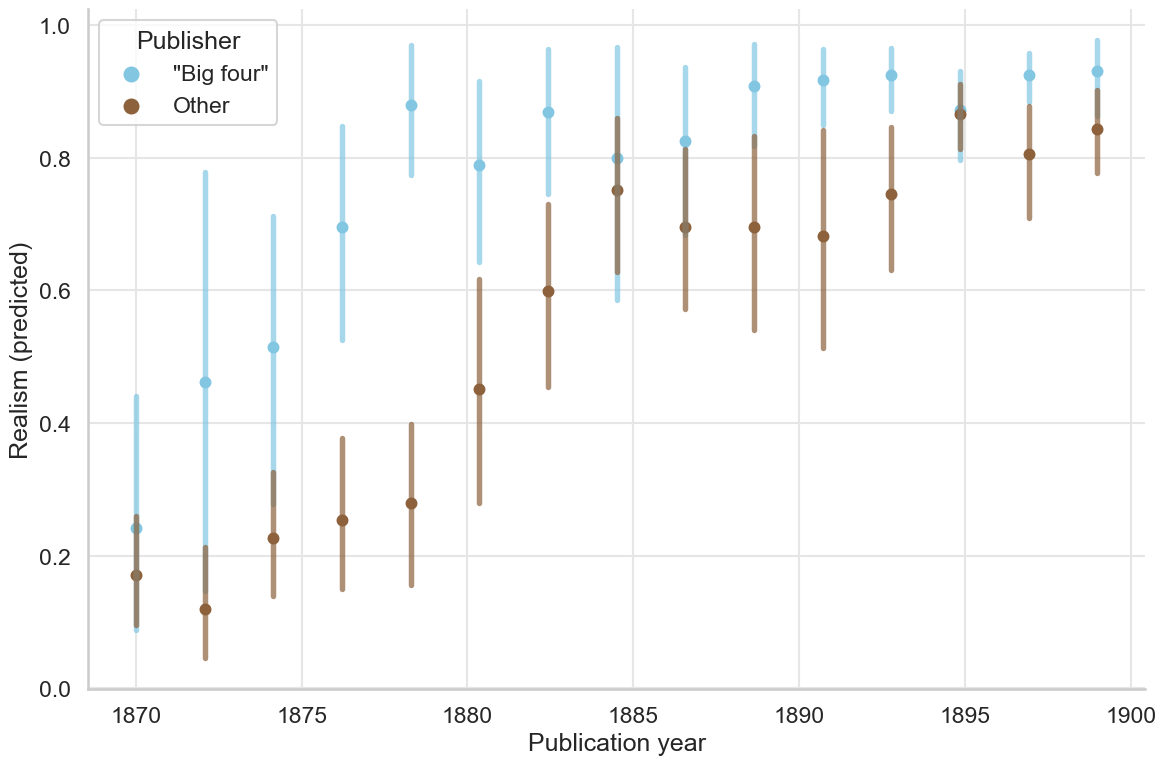

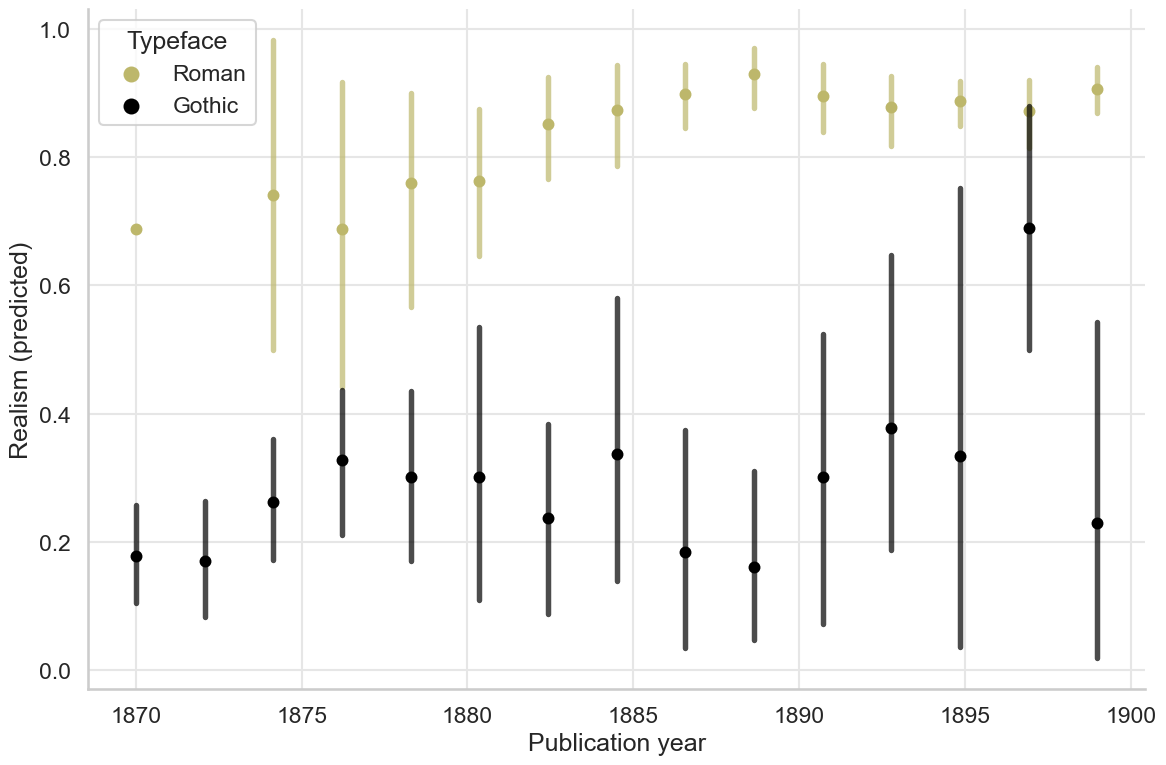

In [71]:
for facet in groups_to_compare:
    g = sns.lmplot(
        x='year',
        y='realism_mixed_probability',
        data=predictions,
        hue=facet,
        fit_reg=False,
        x_bins=np.linspace(1870, 1899, 15),
        height=figsize_std[1],
        aspect=figsize_std[0]/figsize_std[1],
        hue_order = groups_to_compare[facet]['levels'].keys(),
        palette = plot_colors,
        facet_kws={'legend_out':False},
    )
    plt.setp(g.ax.lines, alpha=.7)
    g.set_axis_labels('Publication year', 'Realism (predicted)')
    # check axes and find which one has the legend
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: break
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [100] 
    leg.set_title(groups_to_compare[facet]['display'])
    for t, l in zip(leg.texts, groups_to_compare[facet]['levels'].values()): 
        t.set_text(l)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f'realist_pred_by_year_{facet}'), dpi=300)
    plt.show()

# Multiple linear regression

Let's try to control for linear interactions between inputs so that we can see whether or not differences between facets stand on their own. We're especially concerned about time-correlated variables like length and typeface.

We'll approach this by building a multiple linear regression model. The model treats each year of data as an observation. Its inputs are the mean fraction of the indicated variables for each year. Its output is a prediction of the mixed model's average predicted realism probability for that year.

Once we've built the model, we'll examine its coefficients to get a sense of each variable's relative impact after controlling for all the others.

In [72]:
# prepare data: fraction of each facet by year
#  could do this more elegantly, but ok for now
publication_year = []
women_fraction = []
no_fraction = []
short_fraction = []
cheap_fraction = []
main_publisher_fraction = []
roman_fraction = []
realism_fraction = []

def get_count_value(string_id):
    try:
        return group[facet].value_counts().loc[string_id]
    except KeyError:
        return 0
    
for year, group in predictions.groupby('year'):
    publication_year.append((year-1870)/29)
    realism_fraction.append(group.realism_mixed_probability.mean())
    for facet in groups_to_compare.keys():
        total_volumes = group[facet].value_counts().sum()
        if facet=='gender':
            women_fraction.append(get_count_value('f')/total_volumes)
        elif facet=='nationality':
            no_fraction.append(get_count_value('no')/total_volumes)
        elif facet=='length':
            short_fraction.append(get_count_value('short')/total_volumes)
        elif facet=='cost':
            cheap_fraction.append(get_count_value('cheap')/total_volumes)
        elif facet=='publisher_big':
            main_publisher_fraction.append(get_count_value('main')/total_volumes)
        elif facet=='typeface':
            roman_fraction.append(get_count_value('roman')/total_volumes)
            
linear_model_data = pd.DataFrame(
    data={
        'year':publication_year,
        'women_frac':women_fraction,
        'norway_frac':no_fraction,
        'short_frac':short_fraction,
        'cheap_frac':cheap_fraction,
        'main_pub_frac':main_publisher_fraction,
        'roman_frac':roman_fraction,
        'realism_frac':realism_fraction
    }
)

In [73]:
# build and score the model
X_linear = linear_model_data[linear_model_data.columns[:-1]]
y_linear = linear_model_data['realism_frac']
linear_model = LinearRegression().fit(X_linear, y_linear)
y_pred = linear_model.predict(X_linear)

print(f"Coefficient of determination (r^2): {linear_model.score(X_linear,y_linear)**2:.3f}")

Coefficient of determination (r^2): 0.947


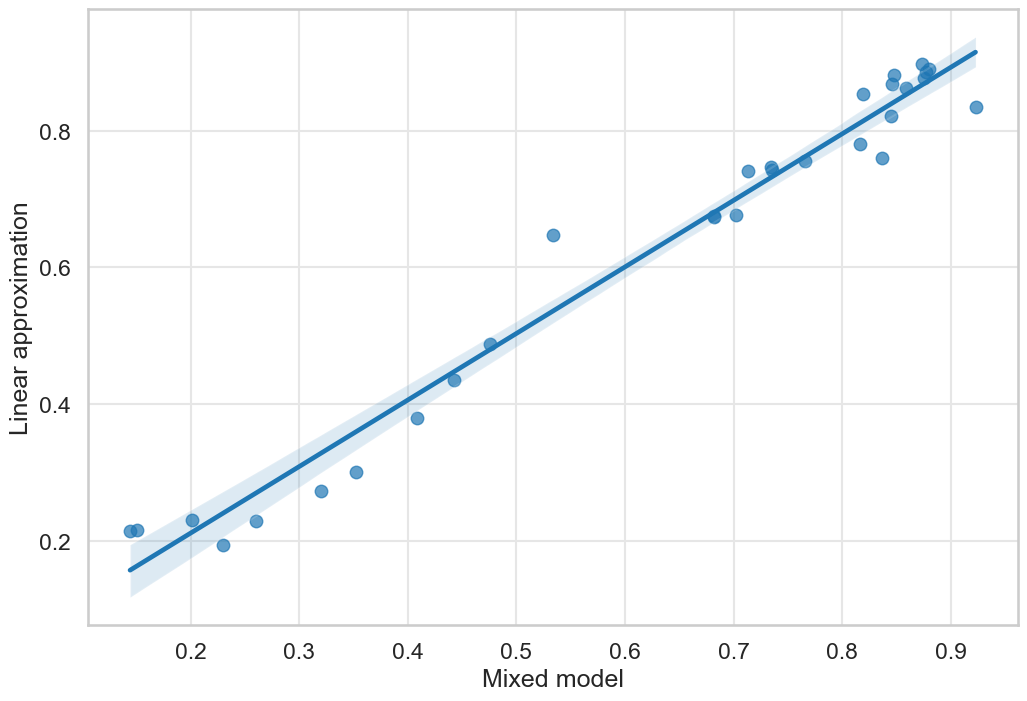

In [74]:
# plot output: linear approximation of annual realism fraction vs mixed model of same
sns.regplot(
    x=y_linear,
    y=y_pred,
    scatter_kws={'alpha':0.7}
)
plt.xlabel("Mixed model")
plt.ylabel("Linear approximation")
plt.savefig(os.path.join(fig_dir, 'mixed_model_linear_approximation'), dpi=300)
plt.show()

In [75]:
# examine coefficients of linear model
sorted_idx = np.argsort(abs(linear_model.coef_))[::-1]
for var, coef in zip(X_linear.columns[sorted_idx], linear_model.coef_[sorted_idx]):
    print(f"{var: <14} {coef:7.4f}")
    
print("-----")
print(f"{'intercept': <14} {linear_model.intercept_:7.4f}")

roman_frac      0.5086
year            0.2273
norway_frac     0.1407
short_frac     -0.0439
women_frac     -0.0372
cheap_frac     -0.0144
main_pub_frac   0.0002
-----
intercept       0.2166


## How to interpret these regression coefficients

The numbers above are the coefficients of a multiple linear regression model that has seven inputs (predictor variables, named as you can see) and one output (trying to reproduce the annual predicted realism probability from the mixed model).

All of the input variables range between zero and one. `year` is the only one that's a little tricky: we set `1870 = 0` and `1899 = 1`. Every other year is measured as the fraction of the linear temporal distance between those start and end dates.

What each of these coefficients means is that, all else being held equal, a full unit change in the indicated variable will produce the indicated change in the output of the model.

For example, the coefficient for the `norway_frac` variable is 0.1407. That means that the predicted realism rate of a set of books with given features will be predicted to be 14.07 percentage points more realist if all of the books are by Norwegian authors rather than by Danish authors.

What these numbers allow us to do is to see how much each variable contributes to our approximated model, controlling for the others. It suggests that **typeface**, **year of publication**, and **author nationality** are strong predictors of realism. Book length, book cost, publisher, and author gender are not especially strong predictors, once we've controlled for the others.

That said, there's a *lot* of covariability between the inputs. I don't think we can be confident that a simple linear model is sorting it all out perfectly. But it's a step in the right direction. 

# Object density

Examine object density metrics, rather than realism as such.

## Object density over time

A different metric entirely, but one to examine alongside realism.

In [76]:
# join object denisty data to predictions data
predictions = predictions.join(properties[object_types])

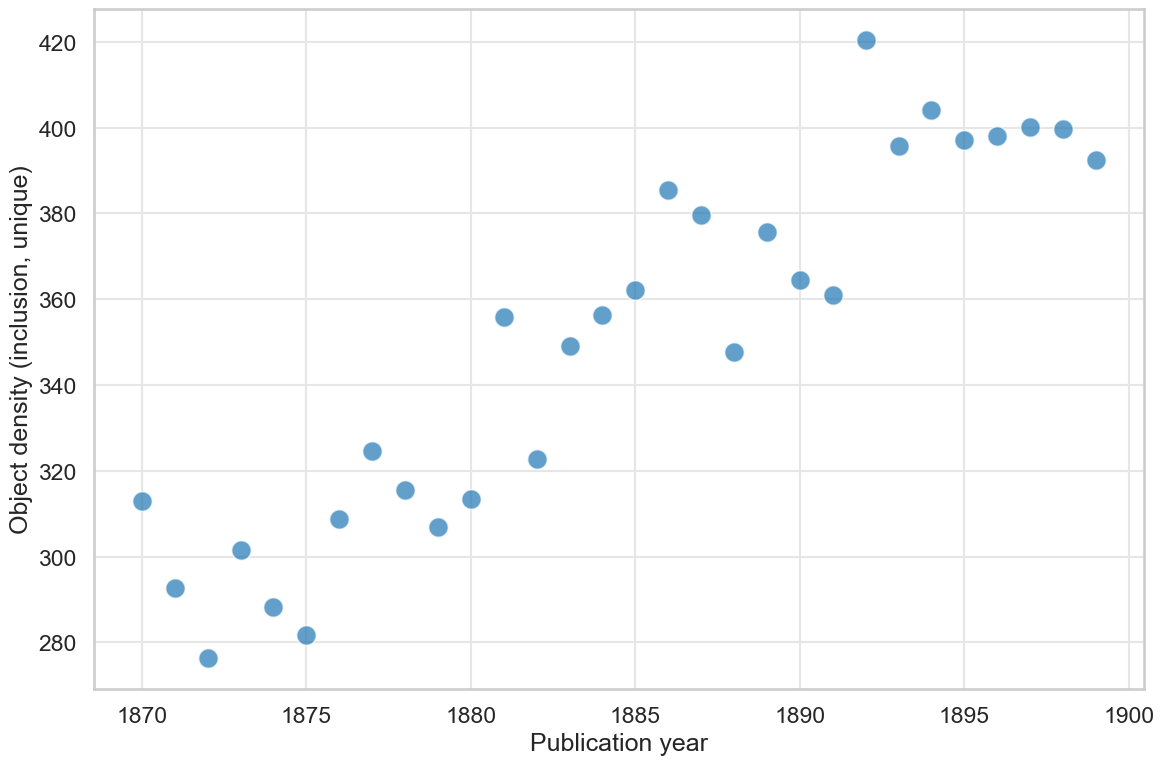

In [77]:
# plot object density by year
years = []
object_densities = []

for name, group in predictions.groupby(['year']):
    years.append(int(name))
    object_densities.append(group['objects_inc_u'].mean())

sns.scatterplot(x=years, y=object_densities, s=200, alpha=0.7)
plt.xlabel('Publication year')
plt.ylabel('Object density (inclusion, unique)')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'objects_inc_u_by_year.png'), dpi=300)
plt.show()

## Statistical significance by group

In [78]:
# calculate means, effect sizes, and permutation p-values per object density measure

for target_col in object_types:
    #if True: # all versions of the metric
    #if target_col.rpartition('_')[-1] == 'u': # just the unique versions
    if target_col == 'objects_inc_u': # focus on the most informative version
        print("================================")
        print(f"Object metric type: {target_col}")
        print("================================")
        for facet in groups_to_compare.keys():
            data_groups = []
            group_labels = []
            for label, group in predictions[[facet, target_col]].groupby(facet):
                group_labels.append(label)
                data_groups.append(group[target_col])
            print(facet)
            print("-----")
            print(f"{group_labels[0]} mean: {data_groups[0].mean():.3f}")
            print(f"{group_labels[1]} mean: {data_groups[1].mean():.3f}")
            print(f"effect size: {effect_size(data_groups[0], data_groups[1], target_col):.2f}")
            perm_test_result = scipy.stats.permutation_test(
                data=data_groups, 
                statistic=means_diff,
                alternative='two-sided'
            )
            print(f"p-value: {perm_test_result.pvalue:.5f}")
            print()

Object metric type: objects_inc_u
gender
-----
f mean: 336.243
m mean: 378.729
effect size: 0.43
p-value: 0.00020

nationality
-----
dk mean: 371.412
no mean: 366.763
effect size: 0.05
p-value: 0.65700

length
-----
long mean: 301.183
short mean: 420.794
effect size: 1.40
p-value: 0.00020

cost
-----
cheap mean: 403.669
expensive mean: 326.711
effect size: 0.80
p-value: 0.00020

publisher_big
-----
main mean: 380.566
other mean: 347.900
effect size: 0.32
p-value: 0.00020

typeface
-----
gothic mean: 300.792
roman mean: 388.152
effect size: 0.91
p-value: 0.00020



## Object density over time by group

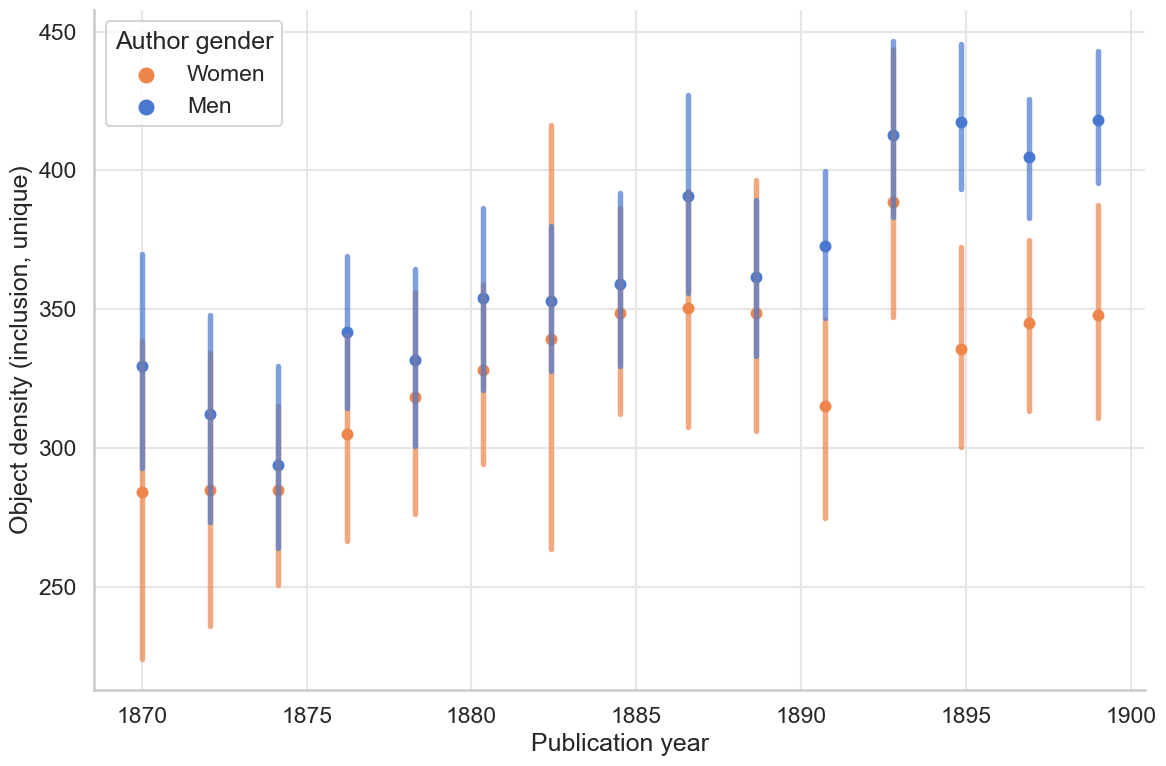

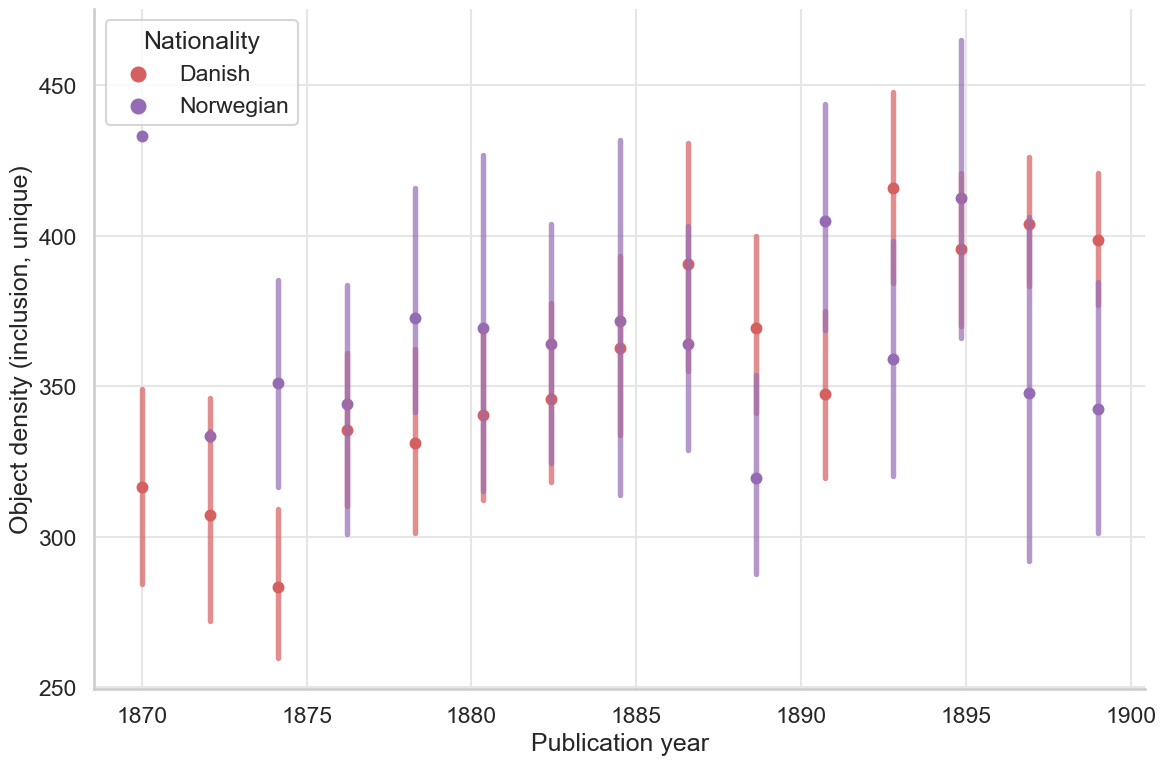

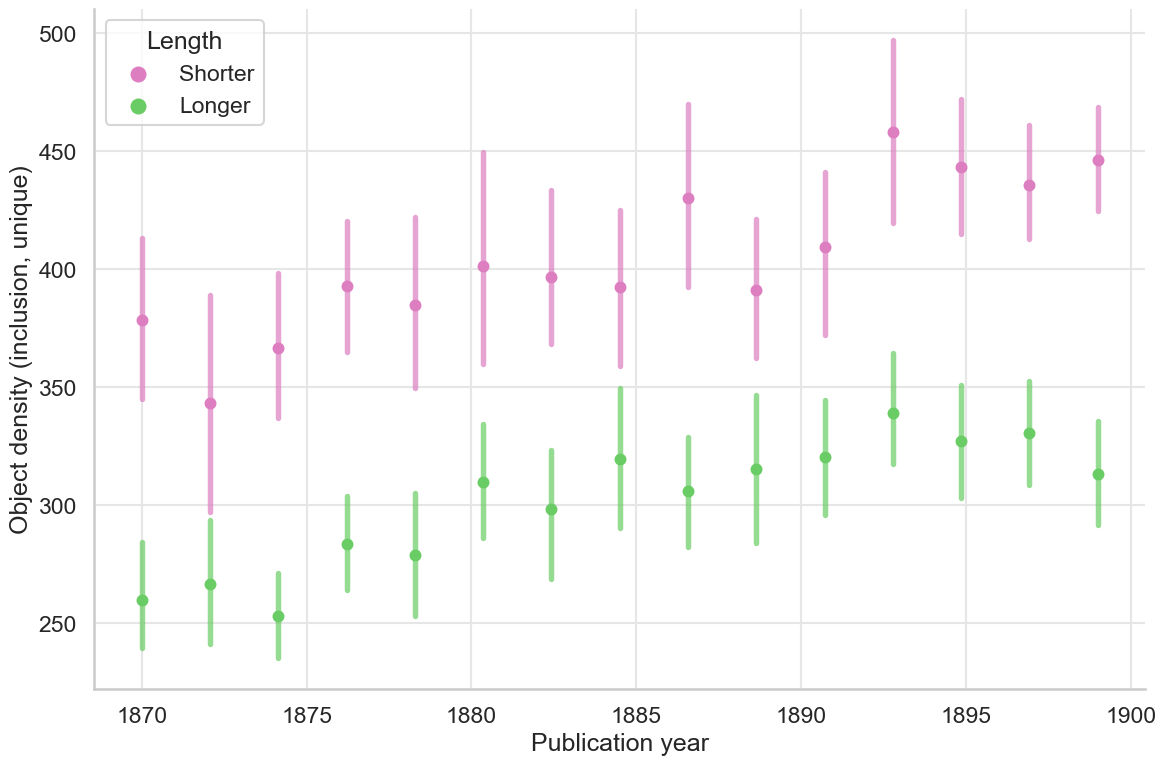

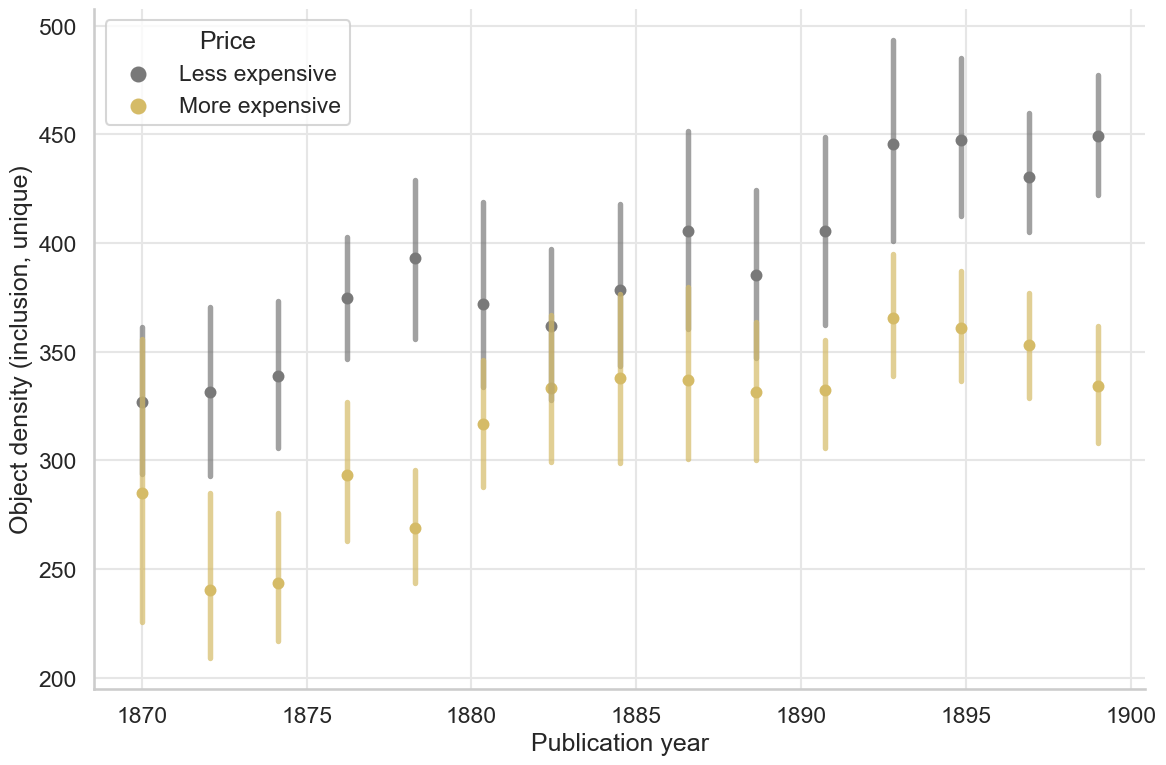

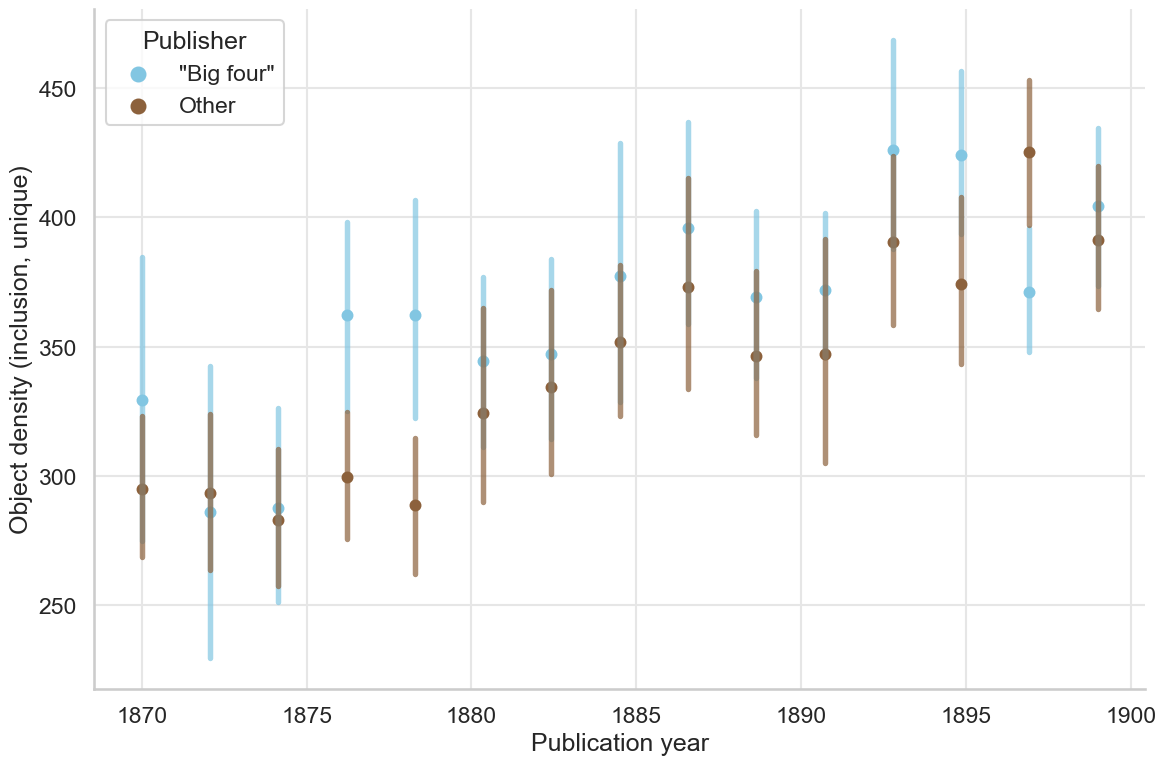

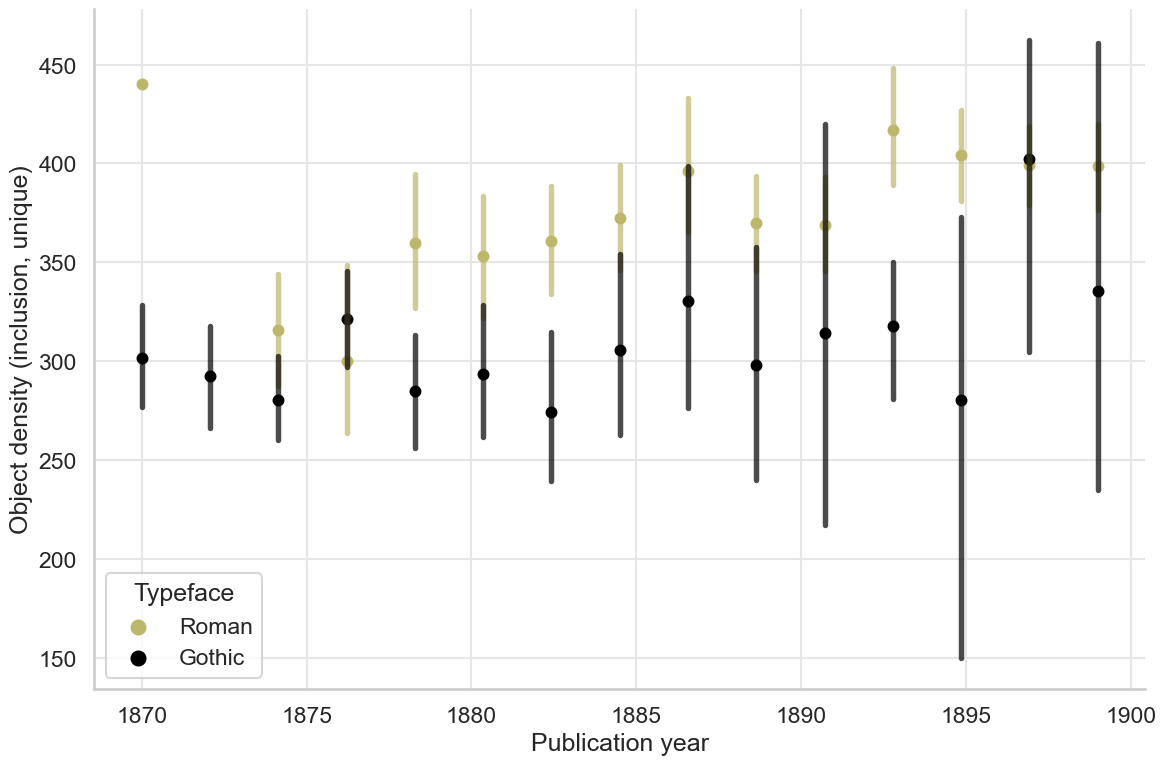

In [79]:
object_labels = {
    'objects_exc_u':'exclusion, unique',
    'objects_inc_u':'inclusion, unique'
}

for target_col in object_types:
    #if True: # all versions of the metric
    #if target_col.rpartition('_')[-1] == 'u': # just the unique versions
    if target_col == 'objects_inc_u': # focus on the most informative version
        for facet in groups_to_compare:
            g = sns.lmplot(
                x='year',
                y=target_col,
                data=predictions,
                hue=facet,
                fit_reg=False,
                x_bins=np.linspace(1870, 1899, 15),
                height=figsize_std[1],
                aspect=figsize_std[0]/figsize_std[1],
                hue_order = groups_to_compare[facet]['levels'].keys(),
                palette = plot_colors,
                facet_kws={'legend_out':False},
            )
            plt.setp(g.ax.lines, alpha=.7)
            g.set_axis_labels('Publication year', f'Object density ({object_labels[target_col]})')
            # check axes and find which one has the legend
            for ax in g.axes.flat:
                leg = g.axes.flat[0].get_legend()
                if not leg is None: break
            # or legend may be on a figure
            if leg is None: 
                leg = g._legend
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
                lh._sizes = [100] 
            leg.set_title(groups_to_compare[facet]['display'])
            for t, l in zip(leg.texts, groups_to_compare[facet]['levels'].values()): 
                t.set_text(l)
            plt.tight_layout()
            plt.savefig(os.path.join(fig_dir, f'{target_col}_by_year_{facet}'), dpi=300)
            plt.show()

## Object density linear model

Just like the realism model above, we attempt to predict the object density metric on the basis of paratextaul info.

In [80]:
# prepare data: fraction of each facet by year
#  could do this more elegantly, but ok for now
object_linear_model_data = pd.DataFrame(
    data={
        'year':[(year-1870)/29 for year in years],
        'object_density':object_densities
    }
)
object_linear_model_data = linear_model_data[linear_model_data.columns[:-1]].merge(object_linear_model_data, on='year')

In [81]:
# build and score the model
X_obj_linear = object_linear_model_data[object_linear_model_data.columns[:-1]]
y_obj_linear = object_linear_model_data['object_density']
obj_linear_model = LinearRegression().fit(X_obj_linear, y_obj_linear)
y_obj_pred = obj_linear_model.predict(X_obj_linear)

print(f"Coefficient of determination (r^2): {obj_linear_model.score(X_obj_linear,y_obj_linear)**2:.3f}")

Coefficient of determination (r^2): 0.808


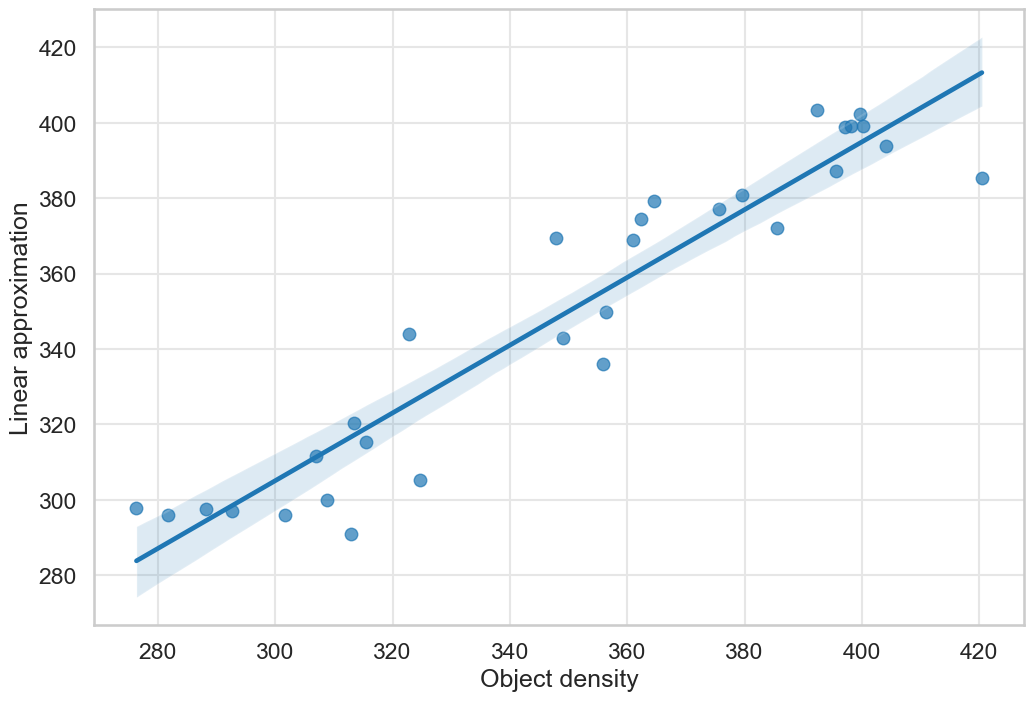

In [82]:
# plot output: linear approximation of annual realism fraction vs mixed model of same
sns.regplot(
    x=y_obj_linear,
    y=y_obj_pred,
    scatter_kws={'alpha':0.7}
)
plt.xlabel("Object density")
plt.ylabel("Linear approximation")
plt.savefig(os.path.join(fig_dir, 'object_density_linear_approximation'), dpi=300)
plt.show()

In [83]:
# examine coefficients of linear model
sorted_idx = np.argsort(abs(obj_linear_model.coef_))[::-1]
for var, coef in zip(X_obj_linear.columns[sorted_idx], obj_linear_model.coef_[sorted_idx]):
    print(f"{var: <14} {coef:7.1f}")
    
print("-----")
print(f"{'intercept': <14} {obj_linear_model.intercept_:7.1f}")

year              70.8
short_frac        64.9
women_frac        33.3
cheap_frac        27.1
roman_frac        26.1
main_pub_frac     17.1
norway_frac       16.8
-----
intercept        237.7


See note on interpreting model coefficients, above, for guidance. Note that the main difference in this case is that the output value being modeled, `object density`, now varies over a much larger range than zero to one. But the interpretive logic is exatly the same. All input values still range between zero and one.